In [1]:
pip install pandas pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import make_column_selector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from googletrans import Translator, LANGUAGES
from scipy.sparse import csr_matrix
from transformers import BertModel, BertTokenizer
from scipy.stats import shapiro, f_oneway, kruskal
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import gensim
import networkx as nx
from itertools import combinations
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sentence_transformers import SentenceTransformer
import pandas as pd
import deepl
import numpy as np
import seaborn as sns
import re
import spacy
import tensorflow as tf
import unicodedata
import matplotlib.pyplot as plt

2024-08-17 16:54:03.458097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
# Load the dataset
file_path = '/Users/xinyingjinzhu/Desktop/PROJECT/GLOVO/Partner Catalogues - 180424.xlsx'

# Load the Excel file into a pandas DataFrame
data = pd.read_excel(file_path)

# Display the first few rows of the DataFrame
print(data.head())

  product_external_id p_country_date        store_name  store_name_grouped  \
0              292092             ES  Supermercado DIA                 NaN   
1                 101             ES  Supermercado DIA                 NaN   
2              197503             ES  Supermercado DIA                 NaN   
3              279225             ES  Supermercado DIA                 NaN   
4              189160             ES  Supermercado DIA                 NaN   

                                        product_name  product_description  \
0  Queso De Oveja Curado Insólito El Cencerro 200...                  NaN   
1        Aceite Refinado de Girasol Dia Botella 1 L.                  NaN   
2           Levadura En Polvo Delimagic Sobre 90 Gr.                  NaN   
3   Licor de Mora sin Alcohol Soñador Botella 70 Cl.                  NaN   
4       Caldo Casero de Verduras Gallina Blanca 1 L.                  NaN   

   product_price                                  product_image_url 

# 1. PREPROCESSING

In [8]:
# Check unique values in specific columns
print("Unique values in 'p_country_date':", data['p_country_date'].unique())
print("Unique values in 'store_name':", data['store_name'].unique())
print("Unique values in 'store_name_grouped':", data['store_name_grouped'].unique())
print("Unique values in 'product_description':", data['product_description'].unique())

Unique values in 'p_country_date': ['ES']
Unique values in 'store_name': ['Supermercado DIA']
Unique values in 'store_name_grouped': [nan]
Unique values in 'product_description': [nan]


In [9]:
# Drop the unnecessary columns
data1 = data.drop(columns=['store_name_grouped'])
data1 = data1.drop(columns=['p_country_date', 'store_name', 'product_is_active'])
print("Cleaned DataFrame head:")
print(data1.head())

Cleaned DataFrame head:
  product_external_id                                       product_name  \
0              292092  Queso De Oveja Curado Insólito El Cencerro 200...   
1                 101        Aceite Refinado de Girasol Dia Botella 1 L.   
2              197503           Levadura En Polvo Delimagic Sobre 90 Gr.   
3              279225   Licor de Mora sin Alcohol Soñador Botella 70 Cl.   
4              189160       Caldo Casero de Verduras Gallina Blanca 1 L.   

   product_description  product_price  \
0                  NaN           3.66   
1                  NaN           1.53   
2                  NaN           0.81   
3                  NaN           2.55   
4                  NaN           2.39   

                                   product_image_url  \
0  https://images.deliveryhero.io/image/global-ca...   
1  https://images.deliveryhero.io/image/global-ca...   
2  https://images.deliveryhero.io/image/global-ca...   
3  https://images.deliveryhero.io/image/global-c

In [10]:
# Check for missing data in all columns
missing_data = data1.isnull().sum()

# Print the results
print("Missing data in each column:")
print(missing_data)

Missing data in each column:
product_external_id                0
product_name                       0
product_description            14825
product_price                      0
product_image_url                  3
groups_collections_sections        0
product_master_code                0
master_category_names             99
product_brand                      0
product_weight_in_grams            0
product_name_english               0
dtype: int64


### 1.1 IDENTIFYING UNIQUE PRODUCT ENTRIES BY 'product_master_code'

In [11]:
# Find unique rows based on 'product_master_code'
df_cleaned = data1.drop_duplicates(subset='product_master_code')

# Display the unique rows
print("Unique rows based on 'product_master_code':")
print(df_cleaned)

Unique rows based on 'product_master_code':
      product_external_id                                       product_name  \
0                  292092  Queso De Oveja Curado Insólito El Cencerro 200...   
1                     101        Aceite Refinado de Girasol Dia Botella 1 L.   
2                  197503           Levadura En Polvo Delimagic Sobre 90 Gr.   
3                  279225   Licor de Mora sin Alcohol Soñador Botella 70 Cl.   
4                  189160       Caldo Casero de Verduras Gallina Blanca 1 L.   
...                   ...                                                ...   
14801              221535      Pasta Fusilloni Dia Delicious Paquete 500 Gr.   
14802              258818  Bálsamo Reparador Multiuso Argán Pieles Secas ...   
14803              190036  Queso de Oveja Curado El Gran Cardenal Cuña 25...   
14820              224310             Bloc Wc Dia Floral Activo Blíster 1 Ud   
14824              240868  Preparado para Pastel de Zanahoria Dr Oetker C...

This reduced the number of rows from the original 14,825 to 8,482. The removed rows represent duplicate entries, helping us focus on distinct product listings in the dataset.

### 1.2 NORMALISATION OF PRODUCT NAMES

In [12]:
df_cleaned = df_cleaned.copy()

# Remove hyphens from product_name and product_name_english columns
df_cleaned.loc[:, 'product_name'] = df_cleaned['product_name'].str.replace('-', ' ', regex=False)
df_cleaned.loc[:, 'product_name_english'] = df_cleaned['product_name_english'].str.replace('-', ' ', regex=False)

# Display a sample of the updated DataFrame
print(df_cleaned[['product_name', 'product_name_english']].head(10))

                                        product_name  \
0  Queso De Oveja Curado Insólito El Cencerro 200...   
1        Aceite Refinado de Girasol Dia Botella 1 L.   
2           Levadura En Polvo Delimagic Sobre 90 Gr.   
3   Licor de Mora sin Alcohol Soñador Botella 70 Cl.   
4       Caldo Casero de Verduras Gallina Blanca 1 L.   
5     Anilla de Pota Dia Mari Marinera Bolsa 350 Gr.   
6      Bebida Energética Wild Pink Frugo Lata 33 Cl.   
7                                Snickers Minis 227g   
8               Picatostes Tostados Dia Bolsa 90 Gr.   
9                        Kiwi Zespri Bandeja 700 Gr.   

                                product_name_english  
0    Insólito El Cencerro Cured Sheep Cheese 200 Gr.  
1                      DiaSol Sunflower Food Oil 1 L  
2  Dia Delimagic Baking Powder Box 5 Sachets of 1...  
3  Alcohol Free Blackberry Liqueur Soñador Bottle...  
4                  Gallina blanca vegetable broth 1L  
5               Pota Ring Dia Mari Marinera 350g Bag 

### 1.3 IMPLEMENTING WEIGHT DATA EXTRACTION

In [13]:
# Modified function to handle non-string inputs by converting all inputs to strings first
def normalize_text(input_text):
    input_text = str(input_text)
    normalized_text = unicodedata.normalize('NFKD', input_text).encode('ascii', 'ignore').decode('ascii')
    return normalized_text.lower()

# Apply normalisation and lowercase conversion to the product names 
df_cleaned.loc[:, 'product_name'] = df_cleaned['product_name'].apply(normalize_text)
df_cleaned.loc[:, 'product_name_english'] = df_cleaned['product_name_english'].apply(normalize_text)
df_cleaned.loc[:, 'product_brand'] = df_cleaned['product_brand'].apply(normalize_text)

# Print
print("DataFrame with normalized and lowercased product names and brands:")
print(df_cleaned[['product_name', 'product_name_english', 'product_brand']].head())

DataFrame with normalized and lowercased product names and brands:
                                        product_name  \
0  queso de oveja curado insolito el cencerro 200...   
1        aceite refinado de girasol dia botella 1 l.   
2           levadura en polvo delimagic sobre 90 gr.   
3   licor de mora sin alcohol sonador botella 70 cl.   
4       caldo casero de verduras gallina blanca 1 l.   

                                product_name_english   product_brand  
0    insolito el cencerro cured sheep cheese 200 gr.     el cencerro  
1                      diasol sunflower food oil 1 l          diasol  
2  dia delimagic baking powder box 5 sachets of 1...             dia  
3  alcohol free blackberry liqueur sonador bottle...         sonador  
4                  gallina blanca vegetable broth 1l  gallina blanca  


In [14]:
# Count the number of products with weight 0
zero_weight_count = (df_cleaned['product_weight_in_grams'] == 0).sum()

print("Number of products with weight 0 grams:", zero_weight_count)

Number of products with weight 0 grams: 2827


In [15]:
def extract_weight(product_name):
    pattern = re.compile(
        r'(\d+)\s*(?:x|X|\*)\s*(\d+\.?\d*)\s*(g\b|gr\b|kg\b|l\b|ml\b|cl\b|lt\b)|'  # Handles multipliers correctly
        r'(\d+)\s+(?:sachets\b|packets\b|pieces\b|packs\b|units\b)\s+of\s+(\d+\.?\d*)\s*(g\b|gr\b|kg\b|l\b|ml\b|cl\b|lt\b)|'
        r'(\d+\.?\d*)\s*(g\b|gr\b|kg\b|l\b|ml\b|cl\b|lt\b)[\.\s]*$',  # Standard weight/volume descriptions
        flags=re.IGNORECASE
    )
    matches = pattern.findall(product_name)
    total_weight = 0

    for groups in matches:
        quantity1, amount1, unit1, quantity2, amount2, unit2, direct_amount, direct_unit = groups

        # Adjust handling for direct amount cases
        if direct_amount and direct_unit:
            quantity = 1  # Assume quantity is 1 unless specified
            amount = float(direct_amount)
            unit = direct_unit
        else:
            quantity = int(quantity1) if quantity1 else int(quantity2) if quantity2 else 1
            amount = float(amount1) if amount1 else float(amount2)
            unit = unit1 if unit1 else unit2

        # Convert weights to grams
        if unit in ['g', 'gr']:
            total_weight += quantity * amount
        elif unit == 'kg':
            total_weight += quantity * amount * 1000
        elif unit in ['l', 'ml', 'cl', 'lt']:
            if unit in ['l', 'lt']:  # Convert liters to grams assuming density of water
                total_weight += quantity * amount * 1000
            elif unit == 'ml':
                total_weight += quantity * amount
            elif unit == 'cl':
                total_weight += quantity * amount * 10

    return total_weight if total_weight > 0 else 0  # Return 0 for non-zero weights detected to avoid confusion with unprocessed entries

# Applying the function to DataFrame
df_cleaned['extracted_weight'] = df_cleaned['product_name_english'].apply(extract_weight)
df_cleaned.loc[df_cleaned['product_weight_in_grams'] == 0, 'product_weight_in_grams'] = df_cleaned['extracted_weight']

print("Updated DataFrame with corrected weights:")
print(df_cleaned[['product_name_english', 'product_weight_in_grams']].head())

Updated DataFrame with corrected weights:
                                product_name_english  product_weight_in_grams
0    insolito el cencerro cured sheep cheese 200 gr.                    195.0
1                      diasol sunflower food oil 1 l                   1021.0
2  dia delimagic baking powder box 5 sachets of 1...                     75.0
3  alcohol free blackberry liqueur sonador bottle...                    728.0
4                  gallina blanca vegetable broth 1l                   1000.0


In [16]:
# Check for NaN values in the 'product_weight_in_grams' column
nan_weights = df_cleaned['product_weight_in_grams'].isna() 

# Count the number of NaN values
nan_count = nan_weights.sum()

# Display the count of NaN values
print(f"Number of NaN values in 'product_weight_in_grams': {nan_count}")

nan_rows = df_cleaned[nan_weights]

print("Rows with NaN weights:")
print(nan_rows[['product_name_english', 'product_weight_in_grams']])

Number of NaN values in 'product_weight_in_grams': 0
Rows with NaN weights:
Empty DataFrame
Columns: [product_name_english, product_weight_in_grams]
Index: []


In [17]:
# Check for zero values in the 'product_weight_in_grams' column
zero_weights = df_cleaned['product_weight_in_grams'] == 0

# Count the number of zero values
zero_count = zero_weights.sum()

# Display the count of zero values
print(f"Number of zero values in 'product_weight_in_grams': {zero_count}")

zero_rows = df_cleaned[zero_weights]
print("Rows with zero weights:")
print(zero_rows[['product_name_english', 'product_weight_in_grams']])

Number of zero values in 'product_weight_in_grams': 1187
Rows with zero weights:
                                    product_name_english  \
19     super absorbent extra soft yellow cloth baller...   
37                        colorcrem bleaching kit 1 unit   
42                    cockroach trap home garden 6 units   
45         makeup remover wipes normal skin bonte 30 pcs   
61              dia super paco glass cleaning cloth 1 pc   
...                                                  ...   
14662   ginger with lemon infusion teteria box 25 units.   
14765                       icy brown dye no. 4 86 syoss   
14768  violet microcapsule dia concentrated fabric so...   
14796           airwick freshmatic flowers refill 2 pcs.   
14820                 floral active day wc block blister   

       product_weight_in_grams  
19                         0.0  
37                         0.0  
42                         0.0  
45                         0.0  
61                         0.0  


In [18]:
# Access a specific row by its index
row_to_check = df_cleaned.loc[14768, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 14770th row (selected columns):")
print(row_to_check)

row_to_check = df_cleaned.loc[7466, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 7468th row (selected columns):")
print(row_to_check)

row_to_check = df_cleaned.loc[12164, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 12166th row (selected columns):")
print(row_to_check)

row_to_check = df_cleaned.loc[873, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 875th row (selected columns):")
print(row_to_check)

Data for the 14770th row (selected columns):
product_name_english       violet microcapsule dia concentrated fabric so...
product_weight_in_grams                                                  0.0
Name: 14768, dtype: object
Data for the 7468th row (selected columns):
product_name_english       pocket mentholated tissues 4 layers dia la lla...
product_weight_in_grams                                                  0.0
Name: 7466, dtype: object
Data for the 12166th row (selected columns):
product_name_english       roura candle 150x57 lighting 1 unit
product_weight_in_grams                                    0.0
Name: 12164, dtype: object
Data for the 875th row (selected columns):
product_name_english       zipper freezer bags 1 lt super paco box 15 pcs.
product_weight_in_grams                                                0.0
Name: 873, dtype: object


In [19]:
# Filter the DataFrame to find rows where 'product_weight_in_grams' is 0
zero_weight_df = df_cleaned[df_cleaned['product_weight_in_grams'] == 0]

# Sample a number of entries randomly from the zero weight DataFrame
random_samples = zero_weight_df.sample(n=15, random_state=42) 

zero_product_list = list(zip(random_samples['product_name_english'], random_samples['product_weight_in_grams']))

# Print
print("Random sample of products with zero weights:")
for product, weight in zero_product_list:
    print(f"Product Name: {product}, Weight: {weight}")

Random sample of products with zero weights:
Product Name: oral b precision brush refill cl.ean 1 unit, Weight: 0.0
Product Name: sensitive condoms imaqe box 12 pcs., Weight: 0.0
Product Name: sharky pierrot children's dental kit case 1 pc., Weight: 0.0
Product Name: aluminum foil alumfix roll 50 m., Weight: 0.0
Product Name: colgate extracl.ean 2+2 brushes 4 pcs., Weight: 0.0
Product Name: strong self closing garbage bag 30 liters vileda 15 pcs., Weight: 0.0
Product Name: san miguel special beer can 33 cl. pack 12 units, Weight: 0.0
Product Name: clean cotton scented candle aromatium box 1 pc., Weight: 0.0
Product Name: dia bloco wc active hygiene oceano 1 un, Weight: 0.0
Product Name: mint poleo infusion hornimans box 40 bags, Weight: 0.0
Product Name: sayma terry sponge set bag 2 pcs., Weight: 0.0
Product Name: codan mini chocolate shells 180g pack, Weight: 0.0
Product Name: avecrem low salt chicken broth 10 tablets, Weight: 0.0
Product Name: mint flavor coated chewing gum orbit pac

In [20]:
# Filter the DataFrame to include only rows where 'product_weight_in_grams' is 0
zero_weights_df = df_cleaned[df_cleaned['product_weight_in_grams'] == 0]

# Group by 'master_category_names' and count zero weights in each category
zero_weights_by_category = zero_weights_df.groupby('master_category_names').size()

total_and_zero_by_category = df_cleaned.groupby('master_category_names').agg(
    total_products=pd.NamedAgg(column='product_name_english', aggfunc='count'),
    zero_weights=pd.NamedAgg(column='product_weight_in_grams', aggfunc=lambda x: (x == 0).sum())
)

# Print
print("Zero weights by category:")
print(zero_weights_by_category)

print("\nTotal products and zero weights by category:")
print(total_and_zero_by_category)

Zero weights by category:
master_category_names
Beverages_Juice / Ice Tea / Sports / Energy_Juice     7
Beverages_Soft Drinks / Mixers_Orange                 1
Beverages_Soft Drinks / Mixers_Other Soft Drinks      2
Bread / Bakery_Bread_Packaged                         4
Bread / Bakery_Sweet Bakery_Packaged                  9
                                                     ..
Snacks_Confectionary_Candies                          4
Snacks_Confectionary_Chocolate                       13
Snacks_Confectionary_Gums                             7
Snacks_Other Snacks_Protein Snacks                    2
Snacks_Salty Snacks_Chips                             1
Length: 83, dtype: int64

Total products and zero weights by category:
                                                    total_products  \
master_category_names                                                
Beverages_Juice / Ice Tea / Sports / Energy_Energy              33   
Beverages_Juice / Ice Tea / Sports / Energy_Ice...     

In [21]:
# Filter for the specific category and zero weights
specific_category_zero_weights = df_cleaned[
    (df_cleaned['master_category_names'] == "Beverages_Juice / Ice Tea / Sports / Energy_Juice") &
    (df_cleaned['product_weight_in_grams'] == 0)
]

# Select the product names of the filtered results
product_names_with_zero_weights = specific_category_zero_weights['product_name_english']

# Print
print("Products with zero weights in 'Beverages_Juice / Ice Tea / Sports / Energy_Juice':")
print(product_names_with_zero_weights)

Products with zero weights in 'Beverages_Juice / Ice Tea / Sports / Energy_Juice':
1895                           turkey cannelloni 20 units
2480    bifrutas mediterranean pascual original 200 ml...
3413                 orange juice pet with pulp sim on lt
4403                    pascual tropical bifrutas 6 units
5605    bifrutas mediterranean pascual original 330 ml...
7666             fruit+milk don simon caribe zero 6 units
9215                         mango nectar dia 1 l. bottle
Name: product_name_english, dtype: object


There are some categories that should be excluded for the weight extraction as they have numbers that mean capacity and not weight. For instance: "zipper freezer bags 2 lt super paco box 15 pcs.", the 2 lt is the capacity and not the weight.

In [22]:
def extract_weight(product_name, category_name):
    # Define categories to exclude from weight extraction
    excluded_categories = ['Home / Pet_Disposables_Food Storage / Wraps']

    # Skip extraction if the category should be excluded
    if category_name in excluded_categories:
        return 0

    # Regex pattern to extract weight
    pattern = re.compile(
        r'(\d+)\s*uds\s+(\d+\.?\d*)\s*(ml|l)\b|'
        r'(\d+)\s*(?:x|X|\*)\s*(\d+\.?\d*)\s*(g|gr|kg|l|ml|cl|lt)\.?|' 
        r'(\d+)\s+(sachets|packets|pieces|packs|units|uds)\s+of\s+(\d+\.?\d*)\s*(g|gr|kg|l|ml|cl|lt)\.?|' 
        r'(\d+\.?\d*)\s*(g|gr|kg|l|ml|cl|lt)\.?\b',
        flags=re.IGNORECASE
    )
    matches = pattern.findall(product_name)
    total_weight = 0

    for match in matches:
        values = [float(v) for v in match if v and v.isdigit() or '.' in v]
        units = [u for u in match if u.isalpha()]

        if values and units:
            quantity = values[0]
            amount = values[1] if len(values) > 1 else 1
            unit = units[0]

            if unit in ['g', 'gr']:
                total_weight += quantity * amount
            elif unit == 'kg':
                total_weight += quantity * amount * 1000
            elif unit in ['l', 'ml', 'cl', 'lt']:
                if unit in ['l', 'lt']:
                    total_weight += quantity * amount * 1000
                elif unit == 'ml':
                    total_weight += quantity * amount
                elif unit == 'cl':
                    total_weight += quantity * amount * 10

    return total_weight if total_weight > 0 else 0

# Apply the function excluding specified categories
df_cleaned['extracted_weight'] = df_cleaned.apply(lambda x: extract_weight(x['product_name'], x['master_category_names']) if x['product_weight_in_grams'] == 0 else x['product_weight_in_grams'], axis=1)

# Update product weights where still zero
df_cleaned.loc[df_cleaned['product_weight_in_grams'] == 0, 'product_weight_in_grams'] = df_cleaned['extracted_weight']

# Recalculate zero count
zero_weight_count = (df_cleaned['product_weight_in_grams'] == 0).sum()
print(f"Number of zero weights after additional extraction: {zero_weight_count}")

Number of zero weights after additional extraction: 992


In [23]:
# Filter for the specific category and zero weights
specific_category_zero_weights = df_cleaned[
    (df_cleaned['master_category_names'] == "Beverages_Juice / Ice Tea / Sports / Energy_Juice") &
    (df_cleaned['product_weight_in_grams'] == 0)
]

# Select the product names of the filtered results
product_names_with_zero_weights = specific_category_zero_weights['product_name']

# Print
print("Products with zero weights in 'Beverages_Juice / Ice Tea / Sports / Energy_Juice':")
print(product_names_with_zero_weights)

Products with zero weights in 'Beverages_Juice / Ice Tea / Sports / Energy_Juice':
Series([], Name: product_name, dtype: object)


In [24]:
# Access a specific row by its index 
row_to_check = df_cleaned.loc[14768, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 14770th row (selected columns):")
print(row_to_check)

row_to_check = df_cleaned.loc[7466, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 7468th row (selected columns):")
print(row_to_check)

row_to_check = df_cleaned.loc[12164, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 12166th row (selected columns):")
print(row_to_check)

row_to_check = df_cleaned.loc[873, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 875th row (selected columns):")
print(row_to_check)

Data for the 14770th row (selected columns):
product_name_english       violet microcapsule dia concentrated fabric so...
product_weight_in_grams                                                  0.0
Name: 14768, dtype: object
Data for the 7468th row (selected columns):
product_name_english       pocket mentholated tissues 4 layers dia la lla...
product_weight_in_grams                                                  0.0
Name: 7466, dtype: object
Data for the 12166th row (selected columns):
product_name_english       roura candle 150x57 lighting 1 unit
product_weight_in_grams                                    0.0
Name: 12164, dtype: object
Data for the 875th row (selected columns):
product_name_english       zipper freezer bags 1 lt super paco box 15 pcs.
product_weight_in_grams                                                0.0
Name: 873, dtype: object


In [25]:
# Access a specific row by its index for selected columns
row_to_check = df_cleaned.loc[4403, ['product_name', 'product_weight_in_grams']]
print("Data for the 4405th row (selected columns):")
print(row_to_check)

Data for the 4405th row (selected columns):
product_name               bebida con leche tropical bifrutas pascual 6 u...
product_weight_in_grams                                               1200.0
Name: 4403, dtype: object


In [26]:
# Access a specific row by its index for selected columns
row_to_check = df_cleaned.loc[7666, ['product_name', 'product_weight_in_grams']]
print("Data for the 7668th row (selected columns):")
print(row_to_check)

Data for the 7668th row (selected columns):
product_name               bebida frutas con leche caribe zero don simon ...
product_weight_in_grams                                               1200.0
Name: 7666, dtype: object


In [27]:
# Filter the DataFrame to include only rows where 'product_weight_in_grams' is 0
zero_weights_df = df_cleaned[df_cleaned['product_weight_in_grams'] == 0]

# Group by 'master_category_names' and count zero weights in each category
zero_weights_by_category = zero_weights_df.groupby('master_category_names').size()

# Alternatively, to see the total number of products and the count of zero weights in each category:
total_and_zero_by_category = df_cleaned.groupby('master_category_names').agg(
    total_products=pd.NamedAgg(column='product_name_english', aggfunc='count'),
    zero_weights=pd.NamedAgg(column='product_weight_in_grams', aggfunc=lambda x: (x == 0).sum())
)

# Print the results
print("Zero weights by category:")
print(zero_weights_by_category)

print("\nTotal products and zero weights by category:")
print(total_and_zero_by_category)

Zero weights by category:
master_category_names
Bread / Bakery_Bread_Packaged                                                                3
Bread / Bakery_Sweet Bakery_Packaged                                                         4
Dairy / Chilled / Eggs_Dairy / Eggs_Eggs                                                    19
Dairy / Chilled / Eggs_Milk_Long Life / UHT                                                  2
Frozen_Frozen Convenience / Bakery_Ready To Cook Meals                                       1
Home / Pet_Cleaning / Laundry_Cleaning                                                     107
Home / Pet_Cleaning / Laundry_Laundry                                                      137
Home / Pet_Disposables_Cleaning Tools                                                       18
Home / Pet_Disposables_Food Storage / Wraps                                                 21
Home / Pet_Disposables_Paper Products                                                       68
Ho

In [28]:
# Filter for the specific category and zero weights
specific_category_zero_weights = df_cleaned[
    (df_cleaned['master_category_names'] == "Bread / Bakery_Bread_Packaged") &
    (df_cleaned['product_weight_in_grams'] == 0)
]

# Select the product names of the filtered results
product_names_with_zero_weights = specific_category_zero_weights['product_name']

# Print 
print("Products with zero weights in 'Bread / Bakery_Bread_Packaged':")
print(product_names_with_zero_weights)

Products with zero weights in 'Bread / Bakery_Bread_Packaged':
226                             bimbo bagels clasicos 4u
8214    bimbo bony bizcocho relleno cubierto de cacao 3u
9554                               baguette schar 2 uds.
Name: product_name, dtype: object


In [29]:
# Filter for the specific category and zero weights
specific_category_zero_weights = df_cleaned[
    (df_cleaned['master_category_names'] == "Dairy / Chilled / Eggs_Dairy / Eggs_Eggs") &
    (df_cleaned['product_weight_in_grams'] == 0)
]

# Select the product names of the filtered results
product_names_with_zero_weights = specific_category_zero_weights['product_name']

# Print
print("Products with zero weights in 'Dairy / Chilled / Eggs_Dairy / Eggs_Eggs':")
print(product_names_with_zero_weights)

Products with zero weights in 'Dairy / Chilled / Eggs_Dairy / Eggs_Eggs':
147      huevos frescos categoria a clase xl huevos gar...
400      huevos frescos categoria a clase m huevos garr...
734      huevos frescos categoria a clase l huevos garr...
862      huevos frescos maiz categoria a clase l demill...
1696     huevos frescos maiz categ a clase m grupo de l...
4504     huevos frescos categoria a clase m rita y pita...
4552     huevos frescos categoria a clase xl estuche 6 ...
4803     huevos gallinas en suelo cat. a clase l la rec...
5005     huevos frescos categoria a clase l rita y pita...
5790     huevos camperos categoria a clase m/l la recet...
6700     huevos frescos categoria a clase l estuche 12 ...
6982     huevos ecologicos categoria a clase m/l la rec...
7344     huevos frescos categoria a clase m estuche 12 ...
8332     huevos frescos categoria a clase m la receta 2...
8790     huevos frescos categoria a clase l aldeovo 12 ...
9186     huevos gallinas en suelo cat. a 

Manually checked, these products don't have their weights 

### 1.4 IDENTIFYING MISSING 'master_category_names'

In [30]:
# Trim whitespace and correct case issues
df_cleaned['master_category_names'] = df_cleaned['master_category_names'].str.strip().str.lower()

# List unique categories
unique_categories = df_cleaned['master_category_names'].unique()
print("Unique Master Category Names:")
print(unique_categories)

Unique Master Category Names:
['dairy / chilled / eggs_dairy / eggs_cheese'
 'packaged foods_cooking / condiments / baking / herbs / spices_condiments'
 'packaged foods_cooking / condiments / baking / herbs / spices_baking'
 'bws_spirits_liqueurs / creams'
 'packaged foods_canned / jarred / instant meals_instant meals'
 'meat / seafood_fish / seafood_fish'
 'beverages_juice / ice tea / sports / energy_energy'
 'snacks_confectionary_chocolate' 'bread / bakery_bread_packaged'
 'produce_fruit_other' 'dairy / chilled / eggs_deli / snacking_deli meat'
 'beverages_juice / ice tea / sports / energy_juice'
 'dairy / chilled / eggs_dairy / eggs_yoghurt'
 'packaged foods_canned / jarred / instant meals_canned vegetables'
 'personal care / baby / health_personal care / beauty_skin care'
 'personal care / baby / health_personal care / beauty_hair care'
 'home / pet_cleaning / laundry_cleaning'
 'personal care / baby / health_personal care / beauty_body products'
 'packaged foods_canned / jarred / 

In [31]:
# Frequency distribution of categories
category_distribution = df_cleaned['master_category_names'].value_counts()
print("\nCategory Distribution:")
print(category_distribution)


Category Distribution:
personal care / baby / health_personal care / beauty_skin care          349
personal care / baby / health_personal care / beauty_hair care          342
home / pet_cleaning / laundry_cleaning                                  301
snacks_confectionary_chocolate                                          279
packaged foods_canned / jarred / instant meals_canned meat / seafood    270
                                                                       ... 
beverages_soft drinks / mixers_other mixers                               1
general merchandise_electronics_other electronics                         1
bws_spirits_fruits                                                        1
produce_fruit_berries                                                     1
beverages_specialty_organic sodas                                         1
Name: master_category_names, Length: 174, dtype: int64


In [32]:
# Filter rows where 'master_category_names' is missing
missing_category_df = df_cleaned[df_cleaned['master_category_names'].isna()]

# Select 'product_name_english' from these filtered rows
missing_category_products = missing_category_df['product_name_english']

# Print the product names with missing category names
print("Products with Missing Category Names:")
print(missing_category_products)

Products with Missing Category Names:
217      pack 4 latas nestea + 4 latas nestea limon sin...
427                      pack pizza  + refresco de naranja
434               pack cerveza mahou 5 estrellas + triskys
637           pack gyozas pollo vici + salsa soja kikkoman
739              pack red bull + ginebra tanqueray + hielo
780      pack 4 latas bebida energetica monster regular...
831              pack merienda leche + croissants de cacao
844                            pack canelones carne y atun
908                           pack 4 latas monster sabores
1529                                   pack 6 latas sprite
1566     pack nocilla original+ nocilla choco leche + p...
1631                        pack pizza + helados + cerveza
1762                      pack tallarines y macarrones dia
1851     pack pizza jamon queso dia al punto envase + c...
2023     pack airwick electrico nenuco aparato + 3 reca...
2787                        pack tomate frito y huevos dia
3022              

There are 99 products with missing master_category_names. These products, when checking their product_name_english, the name is in spanish or wrong translated (like "product_name"), not translated. 

Most of these products are packs. These packs have different category products, such as pack pizza + refresco de naranja (a pizza and a drink), thus, it belongs to none of the categories OR two of the categories. After further inspection, we decide to filter out these rows.

In [33]:
# Filter rows where 'master_category_names' is missing and 'product_name_english' does not contain 'pack'
missing_category_non_pack_products = df_cleaned[
    (df_cleaned['master_category_names'].isna()) & 
    (~df_cleaned['product_name_english'].str.lower().str.contains("pack"))
]

# Select 'product_name_english' from these filtered rows
non_pack_product_names = missing_category_non_pack_products['product_name_english']

# Print the product names with missing category names that do not contain 'pack'
print("Non-Pack Products with Missing Category Names:")
print(non_pack_product_names)

Non-Pack Products with Missing Category Names:
Series([], Name: product_name_english, dtype: object)


They are all packs.

In [34]:
# Remove all rows where 'product_name_english' contains 'pack' and 'master_category_names' is missing
filtered_df = df_cleaned[
    ~(df_cleaned['product_name_english'].str.lower().str.contains('pack') & df_cleaned['master_category_names'].isna())
]

remaining_pack_rows = filtered_df[
    filtered_df['product_name_english'].str.lower().str.contains('pack') & filtered_df['master_category_names'].isna()
]

# Print
print("Filtered DataFrame (without rows containing 'pack' and missing master category names):")
print(filtered_df)
print("Rows that still contain 'pack' and have missing master category names:")
print(remaining_pack_rows)

Filtered DataFrame (without rows containing 'pack' and missing master category names):
      product_external_id                                       product_name  \
0                  292092  queso de oveja curado insolito el cencerro 200...   
1                     101        aceite refinado de girasol dia botella 1 l.   
2                  197503           levadura en polvo delimagic sobre 90 gr.   
3                  279225   licor de mora sin alcohol sonador botella 70 cl.   
4                  189160       caldo casero de verduras gallina blanca 1 l.   
...                   ...                                                ...   
14801              221535      pasta fusilloni dia delicious paquete 500 gr.   
14802              258818  balsamo reparador multiuso argan pieles secas ...   
14803              190036  queso de oveja curado el gran cardenal cuna 25...   
14820              224310             bloc wc dia floral activo blister 1 ud   
14824              240868  prepar

Filtered out all packs.

### 1.5 EXTRACTING PRODUCT QUANTITY FROM ROWS OF MISSING WEIGHT

In [35]:
# Filter rows where product_weight_in_grams is missing or zero
missing_weight_df = filtered_df[(filtered_df['product_weight_in_grams'].isna()) | (filtered_df['product_weight_in_grams'] == 0)]

In [36]:
# Function to extract units/quantities from product names
def extract_units_from_name(product_name):
    pattern = re.compile(r'(\d+)\s*(?:x|X|pcs|pcs\.|pc|pc\.|packets|packets\.|units|units\.|unit|unit\.|un|un\.|lv|lv\.|loads|loads\.|tablets|tablets\.|scoops|scoops\.|sheets|sheets\.|pair|pair\.|doses|doses\.|sachets|sachets\.|rolls|rolls\.|shakes|shakes\.|washes|washes\.|bags|bags\.|vials|vials\.|packs|packs\.|packs\b)\s*(\d+)?')
    match = pattern.search(product_name)
    
    if match:
        quantity = int(match.group(1))
        return quantity
    return None

filtered_df.loc[filtered_df['product_weight_in_grams'] == 0, 'product_in_quantities'] = filtered_df['product_name_english'].apply(extract_units_from_name)

# Print 
missing_weight_df = filtered_df[filtered_df['product_weight_in_grams'] == 0]
print(missing_weight_df[['product_name_english', 'product_weight_in_grams', 'product_in_quantities']])

                                    product_name_english  \
19     super absorbent extra soft yellow cloth baller...   
37                        colorcrem bleaching kit 1 unit   
42                    cockroach trap home garden 6 units   
45         makeup remover wipes normal skin bonte 30 pcs   
61              dia super paco glass cleaning cloth 1 pc   
...                                                  ...   
14662   ginger with lemon infusion teteria box 25 units.   
14765                       icy brown dye no. 4 86 syoss   
14768  violet microcapsule dia concentrated fabric so...   
14796           airwick freshmatic flowers refill 2 pcs.   
14820                 floral active day wc block blister   

       product_weight_in_grams  product_in_quantities  
19                         0.0                    3.0  
37                         0.0                    1.0  
42                         0.0                    6.0  
45                         0.0                   30.0  

/var/folders/fz/xvxn_12s2pb4l91f7r0h6q4c0000gn/T/ipykernel_60157/1706658552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[filtered_df['product_weight_in_grams'] == 0, 'product_in_quantities'] = filtered_df['product_name_english'].apply(extract_units_from_name)


In [37]:
# Filter rows where product_in_quantities is NaN and product_weight_in_grams is 0
nan_quantity_df = filtered_df[(filtered_df['product_weight_in_grams'] == 0) & (filtered_df['product_in_quantities'].isna())]

print("Rows with NaN in 'product_in_quantities':")
print(nan_quantity_df[['product_name_english', 'product_weight_in_grams', 'product_in_quantities']])

Rows with NaN in 'product_in_quantities':
                            product_name_english  product_weight_in_grams  \
65                                green cha 25 a                      0.0   
110              printed super resistant mop dia                      0.0   
213      mega jumbo kitchen roll scottex 1 roll.                      0.0   
226                  bimbo bagel classic 300g x4                      0.0   
270      special cotton mop for difficult floors                      0.0   
...                                          ...                      ...   
14420               kitchen paper absorption dia                      0.0   
14514                      oven paper fliss 8 m.                      0.0   
14600  scented gardenia flower air freshener dia                      0.0   
14765               icy brown dye no. 4 86 syoss                      0.0   
14820         floral active day wc block blister                      0.0   

       product_in_quantities  
65

In [38]:
# Function to extract quantities using specific keywords
def extract_specific_units(product_name):
    pattern = re.compile(r'(\d+)\s*(?:u\b|uds\b|rollo\b|ud\b|lavados\b|par\b|bolsitas\b|capsulas\b|lv\b)', re.IGNORECASE)
    match = pattern.search(product_name)
    
    if match:
        quantity = int(match.group(1))
        return quantity
    return None

# Extract quantities directly into filtered_df
filtered_df.loc[(filtered_df['product_weight_in_grams'] == 0) & (filtered_df['product_in_quantities'].isna()), 'product_in_quantities'] = \
    filtered_df.loc[(filtered_df['product_weight_in_grams'] == 0) & (filtered_df['product_in_quantities'].isna()), 'product_name'].apply(extract_specific_units)

nan_quantity_df = filtered_df[
    (filtered_df['product_weight_in_grams'] == 0) & 
    (filtered_df['product_in_quantities'].isna())
]

# Print
print(f"Number of rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0: {nan_quantity_df.shape[0]}")
print(nan_quantity_df[['product_name', 'product_weight_in_grams', 'product_in_quantities']])

Number of rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0: 50
                                            product_name  \
110               fregona estampada super resistente dia   
270    fregona de algodon especial para suelos dificiles   
591    esparadrapo tejido sin tejer hipoalergenico bo...   
619                papel de aluminio alumfix rollo 50 m.   
704    tinte castano chocolate intensive creme no 3,6...   
1180                  bonte tinte rubio no 8 rubio claro   
1299           bayeta microfibra cristales y espejos dia   
1484   insecticida electrico aparato + recambio casa ...   
1588   tinte rubio extra claro no 110 garnier color s...   
1611      tinte rubio claro intensive creme no 8 palette   
1709                            rollo para todo colhogar   
1726   ambientador absorbeolores aroma lavanda glade ...   
2019               papel de aluminio alumfix rollo 30 m.   
2035               film transparente filmfix rollo 80 m.   
2171      

Manually checked, most items have quantity 1 and therefore not specified in the product name.

In [39]:
# Set 'product_in_quantities' to 1 for rows where 'product_name' contains 'tinte'
filtered_df.loc[filtered_df['product_name'].str.contains('tinte', case=False, na=False), 'product_in_quantities'] = 1

# Set 'product_in_quantities' to 1 for rows where 'product_name' contains 'fregona'
filtered_df.loc[filtered_df['product_name'].str.contains('fregona', case=False, na=False), 'product_in_quantities'] = 1

# Set 'product_in_quantities' to 1 for rows where 'product_name' contains 'cepillo'
filtered_df.loc[filtered_df['product_name'].str.contains('cepillo', case=False, na=False), 'product_in_quantities'] = 1

nan_quantity_df = filtered_df[
    (filtered_df['product_weight_in_grams'] == 0) & 
    (filtered_df['product_in_quantities'].isna())
]

# Print 
print("Rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0:")
print(nan_quantity_df[['product_name', 'product_weight_in_grams', 'product_in_quantities']])

Rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0:
                                            product_name  \
591    esparadrapo tejido sin tejer hipoalergenico bo...   
619                papel de aluminio alumfix rollo 50 m.   
1299           bayeta microfibra cristales y espejos dia   
1484   insecticida electrico aparato + recambio casa ...   
1709                            rollo para todo colhogar   
1726   ambientador absorbeolores aroma lavanda glade ...   
2019               papel de aluminio alumfix rollo 30 m.   
2035               film transparente filmfix rollo 80 m.   
2171                    papel de alumnio dia rollo 30 m.   
3272   avecrem caldo de pollo % natural gallina blanc...   
3443   ambientador tatami japones aparato + recambio ...   
3870                     bolsa isotermica con velcro dia   
4516              papel de aluminio dia super paco 30 m.   
5246   crema vinagre de modena frambuesa alina tu dia...   
5263              film 

Let 'tinte', 'fregona' and 'cepillo' = 1 because these items have 1 unit. 

In [40]:
# Manually updating product_in_quantities for specific rows based on product_name patterns
def update_manual_quantities(filtered_df):
    # Define a mapping of product names to manual quantities
    manual_quantities = {
        "esparadrapo tejido sin tejer hipoalergenico bonte 5Mx2,5 Cm": 5,
        "ambientador tatami japones aparato + recambio ambi pur.": 2,
        "bolsa isotermica con velcro dia": 1,
        "mascarilla facial hidratante aguacate iroha.": 1,
        "pano especial cristales limpiamas": 1,
        "bayeta microfibra cristales y espejos dia": 1,
        "bayeta multifacil super absorbente spontex 2 + 1 gratis.": 3,
        "insecticida electrico aparato + recambio casa jardin.": 2,
        "rollo para todo colhogar": 1,
        "avecrem caldo de pollo % natural gallina blanca estuche": 10,
        "discos activos aparato aroma lima fresca pato": 2,
        "lechuga del pais unidad.": 1,
        
    }

    for index, row in filtered_df.iterrows():
        product_name = row['product_name']
        for pattern, quantity in manual_quantities.items():
            if pattern.lower() in product_name.lower():
                filtered_df.loc[index, 'product_in_quantities'] = quantity
                break

update_manual_quantities(filtered_df)

nan_quantity_df = filtered_df[
    (filtered_df['product_weight_in_grams'] == 0) & 
    (filtered_df['product_in_quantities'].isna())
]

print("Rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0 after manual update:")
print(nan_quantity_df[['product_name', 'product_weight_in_grams', 'product_in_quantities']])

Rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0 after manual update:
                                            product_name  \
619                papel de aluminio alumfix rollo 50 m.   
1726   ambientador absorbeolores aroma lavanda glade ...   
2019               papel de aluminio alumfix rollo 30 m.   
2035               film transparente filmfix rollo 80 m.   
2171                    papel de alumnio dia rollo 30 m.   
4516              papel de aluminio dia super paco 30 m.   
5246   crema vinagre de modena frambuesa alina tu dia...   
5263              film transparente dia super paco 80 m.   
6449   aceite oliva arbequina dia almazara del olivar...   
7059                         papel de aluminio dia 50 m.   
8165                  film transparente dia rollo 100 m.   
11220             ambientador flor de rosa perfumada dia   
13387                 ambientador automatico dia aparato   
14514                          papel de horno fliss 8 m.   
146

In [41]:
# Set 'product_in_quantities' to 1 for rows where 'product_name' contains 'ambientador'
filtered_df.loc[filtered_df['product_name'].str.contains('ambientador', case=False, na=False), 'product_in_quantities'] = 1

nan_quantity_df = filtered_df[
    (filtered_df['product_weight_in_grams'] == 0) & 
    (filtered_df['product_in_quantities'].isna())
]

# Print 
print("Rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0:")
print(nan_quantity_df[['product_name', 'product_weight_in_grams', 'product_in_quantities']])

Rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0:
                                            product_name  \
619                papel de aluminio alumfix rollo 50 m.   
2019               papel de aluminio alumfix rollo 30 m.   
2035               film transparente filmfix rollo 80 m.   
2171                    papel de alumnio dia rollo 30 m.   
4516              papel de aluminio dia super paco 30 m.   
5246   crema vinagre de modena frambuesa alina tu dia...   
5263              film transparente dia super paco 80 m.   
6449   aceite oliva arbequina dia almazara del olivar...   
7059                         papel de aluminio dia 50 m.   
8165                  film transparente dia rollo 100 m.   
14514                          papel de horno fliss 8 m.   

       product_weight_in_grams  product_in_quantities  
619                        0.0                    NaN  
2019                       0.0                    NaN  
2035                       0.0    

In [42]:
# Manually update product_weight_in_grams for specific products
def update_weight_for_liquid_products(filtered_df):
    # Mapping of product names to weights in grams
    liquid_weight_mapping = {
        "crema vinagre de modena frambuesa alina tu dia botella 250m": 250, # let 1 ml = 1 g
        "aceite oliva arbequina dia almazara del olivar botella 500m": 500
    }

    for index, row in filtered_df.iterrows():
        product_name = row['product_name']
        for pattern, weight in liquid_weight_mapping.items():
            if pattern.lower() in product_name.lower():
                filtered_df.loc[index, 'product_weight_in_grams'] = weight
                break

update_weight_for_liquid_products(filtered_df)

missing_weight_df = filtered_df[
    (filtered_df['product_weight_in_grams'] == 0)
]

The identified products, "crema vinagre de modena frambuesa alina tu dia botella 250m." and "aceite oliva arbequina dia almazara del olivar botella 500m.," have 'm' as the unit. This 'm' stands for 'ml' (milliliters), indicating the product's volume.

In [43]:
# Access a specific row by its index 
row_to_check = filtered_df.loc[6449, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 6451th row (selected columns):")
print(row_to_check)

row_to_check = filtered_df.loc[5246, ['product_name_english', 'product_weight_in_grams']]
print("Data for the 5248th row (selected columns):")
print(row_to_check)

Data for the 6451th row (selected columns):
product_name_english       arbequina olive oil dia almazara del olivar bo...
product_weight_in_grams                                                500.0
Name: 6449, dtype: object
Data for the 5248th row (selected columns):
product_name_english       dia raspberry modena vinegar cream bottle 250m.
product_weight_in_grams                                              250.0
Name: 5246, dtype: object


We will address the remaining products that lack values in the product_in_quantities column but contain information in meters, identified by the "m." symbol in their product names. We added a feature to the data extraction function to capture these instances, converting the numerical values of meters into the product_in_quantities field.

In [44]:
# Function to extract quantities in meters from product names
def extract_meters(product_name):
    pattern = re.compile(r'(\d+)\s*m\b', re.IGNORECASE)
    match = pattern.search(product_name)
    
    if match:
        return int(match.group(1))
    return None

filtered_df.loc[(filtered_df['product_weight_in_grams'] == 0) & (filtered_df['product_in_quantities'].isna()), 'product_in_quantities'] = \
    filtered_df.loc[(filtered_df['product_weight_in_grams'] == 0) & (filtered_df['product_in_quantities'].isna()), 'product_name'].apply(extract_meters)

nan_quantity_df = filtered_df[
    (filtered_df['product_weight_in_grams'] == 0) & 
    (filtered_df['product_in_quantities'].isna())
]

# Print 
print("Rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0 after meter extraction:")
print(nan_quantity_df[['product_name', 'product_weight_in_grams', 'product_in_quantities']])

Rows with NaN in 'product_in_quantities' and 'product_weight_in_grams' == 0 after meter extraction:
Empty DataFrame
Columns: [product_name, product_weight_in_grams, product_in_quantities]
Index: []


In [45]:
print(filtered_df)

      product_external_id                                       product_name  \
0                  292092  queso de oveja curado insolito el cencerro 200...   
1                     101        aceite refinado de girasol dia botella 1 l.   
2                  197503           levadura en polvo delimagic sobre 90 gr.   
3                  279225   licor de mora sin alcohol sonador botella 70 cl.   
4                  189160       caldo casero de verduras gallina blanca 1 l.   
...                   ...                                                ...   
14801              221535      pasta fusilloni dia delicious paquete 500 gr.   
14802              258818  balsamo reparador multiuso argan pieles secas ...   
14803              190036  queso de oveja curado el gran cardenal cuna 25...   
14820              224310             bloc wc dia floral activo blister 1 ud   
14824              240868  preparado para pastel de zanahoria dr oetker c...   

       product_description  product_pri

In [46]:
# Drop the 'extracted_weight' column
filtered_df = filtered_df.drop(columns=['extracted_weight'])

# Print 
print("Updated DataFrame after removing 'extracted_weight':")
print(filtered_df.head())

Updated DataFrame after removing 'extracted_weight':
  product_external_id                                       product_name  \
0              292092  queso de oveja curado insolito el cencerro 200...   
1                 101        aceite refinado de girasol dia botella 1 l.   
2              197503           levadura en polvo delimagic sobre 90 gr.   
3              279225   licor de mora sin alcohol sonador botella 70 cl.   
4              189160       caldo casero de verduras gallina blanca 1 l.   

   product_description  product_price  \
0                  NaN           3.66   
1                  NaN           1.53   
2                  NaN           0.81   
3                  NaN           2.55   
4                  NaN           2.39   

                                   product_image_url  \
0  https://images.deliveryhero.io/image/global-ca...   
1  https://images.deliveryhero.io/image/global-ca...   
2  https://images.deliveryhero.io/image/global-ca...   
3  https://images.d

### 1.6 ENHANCING PRODUCT DESCRIPTIONS FOR CONSISTENT CLASSIFICATION

In this step, we will augment the 'product_description' with additional terms, such as 'plant based milk', 'alcohol free', 'low calorie' or 'high protein'.

Let's focus on the milk first.

In [47]:
# Filter rows where 'product_name_english' contains 'milk'
milk_products_df = filtered_df[filtered_df['product_name_english'].str.contains('milk', case=False, na=False)]

print("Products containing 'milk':")
print(milk_products_df[['product_name_english', 'master_category_names']])

unique_milk_categories = milk_products_df['master_category_names'].unique()
print("\nUnique master_category_names for products containing 'milk':")
print(unique_milk_categories)

Products containing 'milk':
                                    product_name_english  \
16        cosmo easter milk chocolate figurines bag 90 g   
26                    nb milk and honey shower gel 600ml   
124                          celtic skimmed milk 1, 5 l.   
149    strawberry flavored fermented milk danone acti...   
194                  puleva semi skimmed calcium milk 1l   
...                                                  ...   
14240  milk chocolate figure three kings riegelein 1 ...   
14345  nenuco bath liquid soap with sweet almond milk...   
14448                     chocolate milka milkinis 87.5g   
14631  bath gel + body milk mineral salts la toja bot...   
14803  el gran cardinal br maturata sheep from raw mi...   

                                   master_category_names  
16                        snacks_confectionary_chocolate  
26     personal care / baby / health_personal care / ...  
124          dairy / chilled / eggs_milk_long life / uht  
149          da

In [48]:
# Filter rows based on the specific 'master_category_names'
milk_alternatives_df = filtered_df[filtered_df['master_category_names'] == 'dairy / chilled / eggs_milk_milk alternatives']

print("Products under 'dairy / chilled / eggs_milk_milk alternatives':")
print(milk_alternatives_df[['product_name_english', 'master_category_names']])

Products under 'dairy / chilled / eggs_milk_milk alternatives':
                                    product_name_english  \
693                                    chufi horchata 1l   
1001                   horchata dia pack 3 units 200 ml.   
1370               soy drink 0% sugar vegedia brick 1 l.   
1424                     alpro unsweetened oat drink 1 l   
1442   fruit with milk drink mediterranean dia zumosf...   
1642           soy drink with calcium vegedia brick 1 l.   
1666                                alpro avena drink 1l   
2688         valio profeel chocolate protein shake 250ml   
2810       tropical fruit milk drink dia zumosfera 1 lt.   
3395   fruit with milk drink caribbean dia zumosfera ...   
3476   fruit with milk drink mediterranean dia zumosf...   
3636                puleva cocoa shake 6 units x 200 ml.   
4025                              alpro almond drink 1 l   
4083   fruit & milk melon watermelon dia zumosfera 3x...   
4842   tropical fruit milk drink dia

In [49]:
# List of keywords to identify plant-based milk products
plant_keywords = ['soy', 'oat', 'almond', 'rice', 'coconut', 'soja', 'avena', 'aveia']

# Function to set product_description to "plant-based" if the product name matches keywords
def add_plant_based_description(row):
    if any(keyword in row['product_name_english'].lower() for keyword in plant_keywords):
        return "plant based"
    return row['product_description']

# Filter the DataFrame for rows that have 'milk' in the category
milk_category_names = ['dairy / chilled / eggs_milk_long life / uht',
                       'dairy / chilled / eggs_milk_fresh milk',
                       'dairy / chilled / eggs_milk_condensed / evaporated milk',
                       'dairy / chilled / eggs_milk_milk powder',
                       'dairy / chilled / eggs_milk_milk alternatives']

# Create a filtered DataFrame to apply the transformation
milk_filtered_df = filtered_df[filtered_df['master_category_names'].isin(milk_category_names)].copy()

milk_filtered_df['product_description'] = milk_filtered_df.apply(add_plant_based_description, axis=1)

filtered_df.update(milk_filtered_df)

In [50]:
# Filter the DataFrame to only include rows with the specified categories
milk_products_df = filtered_df[filtered_df['master_category_names'].isin(milk_category_names)]

# Sample rows
sampled_milk_products = milk_products_df.sample(n=40, random_state=42)
print(sampled_milk_products[['product_name_english', 'product_description']])

                                    product_name_english product_description
8260                           asturiana whole milk 1.5l                 NaN
1567                    lauki whole milk 1 lt. packaging                 NaN
5110                      la lechera condensed milk 370g                 NaN
6162                dia vital bebida de soja natural 1 l         plant based
3615         asturiana lactose free semi skimmed milk 1l                 NaN
1068                          asturian skimmed milk 1,5l                 NaN
9947          fruit & milk caribbean dia zumosfera 1 lt.                 NaN
4027   semi skimmed milk with calcium dia dairy packa...                 NaN
4054                  puleva milk omega3 lactose free 1l                 NaN
1499                              puleva milk omega 3 1l                 NaN
3230                          dia lactea leite magro 1 l                 NaN
4842   tropical fruit milk drink dia zumosfera 3x330 ml.                 NaN

In [51]:
# List of terms and descriptions
descriptions_dict = {
    'vegan': 'vegan',
    'veggi': 'vegan',
    'vegetarian': 'vegetarian',
    'caffeine free': 'caffeine free',
    'gluten free': 'gluten free',
    'sugar free': 'sugar free',
    'lactose free': 'lactose free',
    'salt free': 'salt free',
    'fat free': 'fat free',
    'alcohol free': 'alcohol free',
    'non alcoholic': 'alcohol free',
    'protein': 'high in protein',
    '0 calories': '0 calories',
    'low in calories': 'low in calories',
}

# Function to add descriptions 
def add_descriptions(row):
    descriptions = set()
    
    if pd.notna(row['product_description']):
        descriptions.update(row['product_description'].split())
    
    for term, description in descriptions_dict.items():
        if term in row['product_name_english'].lower():
            descriptions.add(description)

    return ' '.join(descriptions)

filtered_df['product_description'] = filtered_df.apply(add_descriptions, axis=1)

matching_terms = '|'.join(descriptions_dict.keys())
print(filtered_df[filtered_df['product_name_english'].str.contains(matching_terms, case=False, na=False)][['product_name_english', 'product_description']])

                                    product_name_english product_description
3      alcohol free blackberry liqueur sonador bottle...        alcohol free
25     high protein natural yogurt dia lactea cup 300...     high in protein
183              gullon gluten free biscuits sharks 250g         gluten free
201                  nestea lemon sugar free bottle 1,5l          sugar free
207        non alcoholic aperitif martini vibrante 75 cl        alcohol free
...                                                  ...                 ...
13176  lactose and gluten free magdalenas dia bag 230...         gluten free
13290  schar bread mold cereals mastro panettiere glu...         gluten free
13842               sugar free mint pills smint tin 105g          sugar free
14085  sugar free green mint flavor chewing gum mento...          sugar free
14278                  g.gourmet vegetarian breaded 180g          vegetarian

[210 rows x 2 columns]


In [52]:
# Filter the DataFrame to find rows with product_description "alcohol free"
alcohol_free_products = filtered_df[filtered_df['product_description'].str.contains('alcohol free', case=False, na=False)]
print(alcohol_free_products[['product_name_english', 'product_description']])

                                    product_name_english product_description
3      alcohol free blackberry liqueur sonador bottle...        alcohol free
207        non alcoholic aperitif martini vibrante 75 cl        alcohol free
926       alcohol free heineken beer pack 12 cans 33 cl.        alcohol free
1040   alcohol free gentle and fresh mouthwash bonte ...        alcohol free
2283           heineken 0.0 alcohol free lager beer 33cl        alcohol free
2453            mahou 0.0 alcohol free toasted beer 33cl        alcohol free
2830   non alcoholic acorn liqueur la extremena bottl...        alcohol free
3020   strawberry flavor alcohol free mouthwash junio...        alcohol free
3204      tanqueray gin alcohol free non alcoholic 70 cl        alcohol free
4091                    mahou alcohol free beer 6x25 cl.        alcohol free
5021   non alcoholic toasted beer 0.0% alcohol ambar ...        alcohol free
5171         non alcoholic aperitif martini floral 75 cl        alcohol free

In [53]:
# Function to add "alcohol free" to the product description if necessary
def add_alcohol_free_description(row):
    if 'alcohol free' not in row['product_description'].lower():
        return f"{row['product_description']} alcohol free" if pd.notna(row['product_description']) else "alcohol free"
    return row['product_description']

# Normalise master_category_names 
filtered_df['master_category_names'] = filtered_df['master_category_names'].str.strip().str.lower()

filtered_df.loc[filtered_df['master_category_names'] == 'bws_beer / cider_alcohol free', 'product_description'] = filtered_df[filtered_df['master_category_names'] == 'bws_beer / cider_alcohol free'].apply(add_alcohol_free_description, axis=1)
print(filtered_df[filtered_df['master_category_names'] == 'bws_beer / cider_alcohol free'][['product_name_english', 'product_description', 'master_category_names']])

                                    product_name_english  \
669                  ambar gluten free beer bottle 33 cl   
1510                        corona beer 0.0 bottle 33 cl   
1919                          00% san miguel beer 6x25cl   
2078                    san miguel beer 0.0 lemon 33 cl.   
2283           heineken 0.0 alcohol free lager beer 33cl   
2355                         buckler beer 0.0 can 33 cl.   
2453            mahou 0.0 alcohol free toasted beer 33cl   
2791                    moritz water beer 0.0 can 33 cl.   
3180                    toasted gold beer 00 amstel 33cl   
4304        cruzcampo beer without alcohol 0.0o can 33cl   
5046                  san miguel magna red beer 0% 33 cl   
5201                    mahou alcohol free beer can 33cl   
5952    estrella galicia alcohol free beer bottle 6x25cl   
6054           san miguel 0.0 alcohol free beer can 33cl   
9972   cruzcampo beer without alcohol 0.0o bottle 6x25cl   
11007                       00 tostada m

In [54]:
# Count rows with non-empty and non-NaN product_description
non_empty_description_count = filtered_df['product_description'].notna() & filtered_df['product_description'].str.strip().astype(bool)
count = non_empty_description_count.sum()

print(f"Number of rows with a non-NaN product_description: {count}")

Number of rows with a non-NaN product_description: 238


# 2. MODELS

## 2.1 WORD2VEC

### 2.1.1 All Tokens Weight the Same

#### 2.1.1.1 Prepare the text data

In [55]:
# Merge descriptions with names
filtered_df['combined_text'] = filtered_df['product_description'].fillna('') + ' ' + filtered_df['product_name_english'].fillna('')

In [56]:
# Tokenise and filter the text
irrelevant_words = {'box', 'sachets', 'package', 'gr', 'grams', 'kg', 'ml', 'l', 'lt', 'pack', 'of', 'el', 'bag', 'tray', 'mini'}

def tokenize_and_filter(text):
    tokens = gensim.utils.simple_preprocess(text)
    return [token for token in tokens if token not in irrelevant_words]

filtered_df['filtered_tokens'] = filtered_df['combined_text'].apply(tokenize_and_filter)

filtered_df = filtered_df[filtered_df['filtered_tokens'].str.len() > 0]

#### 2.1.1.2 Train Word2Vec Model

In [57]:
model = Word2Vec(sentences=filtered_df['filtered_tokens'], vector_size=100, window=5, min_count=1, workers=4)
model.save("combined_word2vec.model")

In [58]:
# Normalise weights and quantities
scaler = MinMaxScaler()
filtered_df['normalized_weight'] = scaler.fit_transform(filtered_df[['product_weight_in_grams']].fillna(0))
filtered_df['normalized_quantities'] = scaler.fit_transform(filtered_df[['product_in_quantities']].fillna(0))

In [59]:
# Function to average word vectors for a document
def document_vector(tokens, model, weight, quantity):
    tokens = [token for token in tokens if token in model.wv.key_to_index]
    if not tokens:
        return np.zeros(model.vector_size + 2)
    word_vectors = np.mean(model.wv[tokens], axis=0)
    return np.hstack((word_vectors, weight, quantity))

In [60]:
# Apply function to create vectors
filtered_df['doc_vector'] = filtered_df.apply(
    lambda x: document_vector(
        x['filtered_tokens'], model, x['normalized_weight'], x['normalized_quantities']
    ), axis=1
)

#### 2.1.1.3 Utilise Cosine Similarity

In [61]:
filtered_df.reset_index(drop=True, inplace=True)

In [62]:
def calculate_similarity_within_categories(df):
    # Create empty matrix for similarities
    n = len(df)
    similarity_matrix = np.zeros((n, n))
    
    # Compute similarity ONLY within the same category
    categories = df['master_category_names'].unique()
    for category in categories:
        indices = df[df['master_category_names'] == category].index.tolist()
        category_vectors = [df.loc[idx, 'doc_vector'] for idx in indices]
        category_similarity = cosine_similarity(np.array(category_vectors))
        
        for i, idx_i in enumerate(indices):
            for j, idx_j in enumerate(indices):
                similarity_matrix[idx_i, idx_j] = category_similarity[i, j]
    
    return similarity_matrix

similarity_matrix = calculate_similarity_within_categories(filtered_df)

In [63]:
def similar_products(product_index, top_n=5):
    similarity_scores = list(enumerate(similarity_matrix[product_index]))
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_indices = [idx for idx, score in sorted_scores[:top_n+1]]
    return filtered_df.iloc[top_indices][['product_name_english', 'product_description', 'master_category_names']]

In [64]:
print(similar_products(0, 5))

                                   product_name_english product_description  \
0       insolito el cencerro cured sheep cheese 200 gr.                       
8002             cured sheep cheese el cencerro 250 gr.                       
4744              aged sheep cheese el cencerro 250 gr.                       
5921  semi cured sheep cheese slices dia el cencerro...                       
6163  semi cured cheese cut dia el cencerro wedge 25...                       
4525    semi cured cheese dia el cencerro wedge 300 gr.                       

                           master_category_names  
0     dairy / chilled / eggs_dairy / eggs_cheese  
8002  dairy / chilled / eggs_dairy / eggs_cheese  
4744  dairy / chilled / eggs_dairy / eggs_cheese  
5921  dairy / chilled / eggs_dairy / eggs_cheese  
6163  dairy / chilled / eggs_dairy / eggs_cheese  
4525  dairy / chilled / eggs_dairy / eggs_cheese  


In [65]:
print(similar_products(1, 5))

                                   product_name_english product_description  \
1                         diasol sunflower food oil 1 l                       
3993          extra virgin olive oil dcoop bottle 1 lt.                       
3980          extra virgin olive oil dcoop bottle 3 lt.                       
4393        borges high oleic sunflower oil bottle 1 l.                       
1692  extra virgin olive oil dia almazara del olivar...                       
174   extra virgin olive oil dia almazara del olivar...                       

                                  master_category_names  
1     packaged foods_cooking / condiments / baking /...  
3993  packaged foods_cooking / condiments / baking /...  
3980  packaged foods_cooking / condiments / baking /...  
4393  packaged foods_cooking / condiments / baking /...  
1692  packaged foods_cooking / condiments / baking /...  
174   packaged foods_cooking / condiments / baking /...  


In [66]:
print(similar_products(2, 5))

                                   product_name_english product_description  \
2     dia delimagic baking powder box 5 sachets of 1...                       
1237                      dia stevia powder jar 200 gr.                       
8165                    dia powder sweetener jar 75 gr.                       
5898                 delimagic pancake mix dia jar 200g                       
3676                 strawberry gelatin dia box 170 gr.                       
5795                             dia strong flour 1 kg.                       

                                  master_category_names  
2     packaged foods_cooking / condiments / baking /...  
1237  packaged foods_cooking / condiments / baking /...  
8165  packaged foods_cooking / condiments / baking /...  
5898  packaged foods_cooking / condiments / baking /...  
3676  packaged foods_cooking / condiments / baking /...  
5795  packaged foods_cooking / condiments / baking /...  


In [67]:
print(similar_products(3, 5))

                                   product_name_english product_description  \
3     alcohol free blackberry liqueur sonador bottle...        alcohol free   
4545   alcohol free apple liqueur sonador bottle 70 cl.        alcohol free   
2575  non alcoholic acorn liqueur la extremena bottl...        alcohol free   
5601                        brandy 5 years torres 70 cl                       
5201                          jagermeister liqueur 70cl                       
1731                                        malibu 70cl                       

              master_category_names  
3     bws_spirits_liqueurs / creams  
4545  bws_spirits_liqueurs / creams  
2575  bws_spirits_liqueurs / creams  
5601  bws_spirits_liqueurs / creams  
5201  bws_spirits_liqueurs / creams  
1731  bws_spirits_liqueurs / creams  


In [68]:
print(similar_products(10, 5))

                                   product_name_english product_description  \
10    iberian cebo lomo slices 50% dia nuestra alace...                       
4212  iberian cebo ham slices 50% dia nuestra alacen...                       
1559  iberian salami slices dia nuestra alacena 2 x 60g                       
2017    iberian cebo ham 50% dia nuestra alacena 90 gr.                       
4982  turkey mortadella thin slices dia nuestra alac...                       
5959  iberian cebo shoulder 50% dia nuestra alacena ...                       

                                 master_category_names  
10    dairy / chilled / eggs_deli / snacking_deli meat  
4212  dairy / chilled / eggs_deli / snacking_deli meat  
1559  dairy / chilled / eggs_deli / snacking_deli meat  
2017  dairy / chilled / eggs_deli / snacking_deli meat  
4982  dairy / chilled / eggs_deli / snacking_deli meat  
5959  dairy / chilled / eggs_deli / snacking_deli meat  


In [69]:
print(similar_products(11, 5))

                                   product_name_english product_description  \
11                nutrition juice with iron hohes c 1 l                       
78                  don simon orange juice with pulp 1l                       
4081    fruit juice with vitamin d hohes c bottle 1 lt.                       
3994  mind fruit extracts and vitamins juice dia zum...                       
5784  don simon la huerta cranberry apple and grape ...                       
2986               orange juice pet with pulp sim on lt                       

                                  master_category_names  
11    beverages_juice / ice tea / sports / energy_juice  
78    beverages_juice / ice tea / sports / energy_juice  
4081  beverages_juice / ice tea / sports / energy_juice  
3994  beverages_juice / ice tea / sports / energy_juice  
5784  beverages_juice / ice tea / sports / energy_juice  
2986  beverages_juice / ice tea / sports / energy_juice  


In [70]:
print(similar_products(20, 5))

                                   product_name_english product_description  \
20                argan elixir gel natural honey 600 ml                       
2190            natural shower gel honey coconut 600 ml                       
6027       natural honey moisturizing shower gel 675 ml                       
6447  coconut shower gel travel size natural honey 7...                       
1920     pure micellar shower gel natural honey 750 ml.                       
2771  sensitive shower gel natural honey dispenser 7...                       

                                  master_category_names  
20    personal care / baby / health_personal care / ...  
2190  personal care / baby / health_personal care / ...  
6027  personal care / baby / health_personal care / ...  
6447  personal care / baby / health_personal care / ...  
1920  personal care / baby / health_personal care / ...  
2771  personal care / baby / health_personal care / ...  


In [71]:
print(similar_products(21, 5))

                                   product_name_english product_description  \
21      essencials eye makeup remover skin natura 125ml                       
7838    makeup remover for sensitive skin bonte 250 ml.                       
4601        waterproof eye makeup remover bonte 150 ml.                       
8080  waterproof eye makeup remover travel size bont...                       
7732     gentle eye makeup remover bonte bottle 150 ml.                       
8436  eye and lip makeup remover babaria bottle 100 ml.                       

                                  master_category_names  
21    personal care / baby / health_personal care / ...  
7838  personal care / baby / health_personal care / ...  
4601  personal care / baby / health_personal care / ...  
8080  personal care / baby / health_personal care / ...  
7732  personal care / baby / health_personal care / ...  
8436  personal care / baby / health_personal care / ...  


In [72]:
print(similar_products(22, 5))

                        product_name_english product_description  \
22            albo sardines in olive oil 85g                       
4318          cuca sardines in olive oil 82g                       
1304    albo small sardines in olive oil 82g                       
421         albo \"bonito\" in olive oil 82g                       
5759   calvo tuna in olive oil pack 3x52 gr.                       
3080  calvo tuna in olive oil pack 6x420 gr.                       

                                  master_category_names  
22    packaged foods_canned / jarred / instant meals...  
4318  packaged foods_canned / jarred / instant meals...  
1304  packaged foods_canned / jarred / instant meals...  
421   packaged foods_canned / jarred / instant meals...  
5759  packaged foods_canned / jarred / instant meals...  
3080  packaged foods_canned / jarred / instant meals...  


In [73]:
print(similar_products(35, 5))

                                   product_name_english product_description  \
35        shea butter body cream dry skin nivea 400 ml.                       
4759  nourishing body cream very dry skin nivea bott...                       
557   strong dry skin body cream eudermin dispenser ...                       
5723  nivea visage nourishing day cream for dry and ...                       
2403  anti aging hand cream dry skin nivea q10 plus ...                       
5255            nivea day cream normal skin spf 30 50ml                       

                                  master_category_names  
35    personal care / baby / health_personal care / ...  
4759  personal care / baby / health_personal care / ...  
557   personal care / baby / health_personal care / ...  
5723  personal care / baby / health_personal care / ...  
2403  personal care / baby / health_personal care / ...  
5255  personal care / baby / health_personal care / ...  


In [74]:
print(similar_products(37, 5))

                                   product_name_english product_description  \
37                       colorcrem bleaching kit 1 unit                       
3864  ultra moisturizing sock for feet imaqe bag 2 u...                       
2023        exfoliating sock for feet imaqe bag 2 units                       
1029  firming body milk with vitamin c and q10 imaqe...                       
7943  moisturizing body milk with aloe vera and hyal...                       
5473  nourishing body milk with almonds and probioti...                       

                                  master_category_names  
37    personal care / baby / health_personal care / ...  
3864  personal care / baby / health_personal care / ...  
2023  personal care / baby / health_personal care / ...  
1029  personal care / baby / health_personal care / ...  
7943  personal care / baby / health_personal care / ...  
5473  personal care / baby / health_personal care / ...  


In [75]:
print(similar_products(39, 5))

                                   product_name_english product_description  \
39         day snack maniac! 130 g barbecue corn strips                       
498            day snack maniac! nachos jalapenho 150 g                       
1156               day snack maniac! aprious cones 85 g                       
1527  barbecue flavored fried corn dia snack maniac ...                       
7867    potato cheese flavored snack maniac bag 150 gr.                       
888   cheese flavored ganchitos snack maniac bag 80 gr.                       

          master_category_names  
39    snacks_salty snacks_chips  
498   snacks_salty snacks_chips  
1156  snacks_salty snacks_chips  
1527  snacks_salty snacks_chips  
7867  snacks_salty snacks_chips  
888   snacks_salty snacks_chips  


In [76]:
print(similar_products(47, 5))

                                   product_name_english product_description  \
47                         extra chorizo el pozo 85 gr.                       
1684               extra spicy chorizo ezequiel 425 gr.                       
4678               extra sweet chorizo ezequiel 425 gr.                       
4788        extra chorizo without colorants dia 385 gr.                       
8298      extra spicy sarta chorizo dia package 280 gr.                       
8205  extra chorizo petals 50% duroc boadas pack 80 gr.                       

                                 master_category_names  
47    dairy / chilled / eggs_deli / snacking_deli meat  
1684  dairy / chilled / eggs_deli / snacking_deli meat  
4678  dairy / chilled / eggs_deli / snacking_deli meat  
4788  dairy / chilled / eggs_deli / snacking_deli meat  
8298  dairy / chilled / eggs_deli / snacking_deli meat  
8205  dairy / chilled / eggs_deli / snacking_deli meat  


In [77]:
print(similar_products(49, 5))

                              product_name_english product_description  \
49     salmon pate dia nuestra alacena jar 110 gr.                       
7863      ham pate dia nuestra alacena jar 110 gr.                       
3040  anchovy pate dia nuestra alacena jar 110 gr.                       
5493  chicken pate dia nuestra alacena jar 110 gr.                       
7749               pork liver pate dia jar 200 gr.                       
4284                  dia country pate jar 125 gr.                       

                                  master_category_names  
49    packaged foods_canned / jarred / instant meals...  
7863  packaged foods_canned / jarred / instant meals...  
3040  packaged foods_canned / jarred / instant meals...  
5493  packaged foods_canned / jarred / instant meals...  
7749  packaged foods_canned / jarred / instant meals...  
4284  packaged foods_canned / jarred / instant meals...  


In [78]:
print(similar_products(60, 5))

                               product_name_english product_description  \
60          extra fig jam 60% fruit dia jar 320 gr.                       
509                 extra peach jam dia jar 390 gr.                       
55                     extra peach jam dia jar 640g                       
6082     extra peach diet jam dia vital jar 330 gr.                       
5049  blueberry extra jam dia delicious jar 320 gr.                       
6124  raspberry extra jam dia delicious jar 320 gr.                       

                       master_category_names  
60    packaged foods_breakfast / spreads_jam  
509   packaged foods_breakfast / spreads_jam  
55    packaged foods_breakfast / spreads_jam  
6082  packaged foods_breakfast / spreads_jam  
5049  packaged foods_breakfast / spreads_jam  
6124  packaged foods_breakfast / spreads_jam  


In [79]:
print(similar_products(811, 5))

                product_name_english product_description  \
811               native milk 3 800g                       
2513    ideal evaporated milk 525 ml                       
4294  la lechera condensed milk 370g                       
6998  la lechera condensed milk 450g                       
2845  la lechera condensed milk 740g                       
6235   mardel milk sweet jar 450 gr.                       

                                  master_category_names  
811   dairy / chilled / eggs_milk_condensed / evapor...  
2513  dairy / chilled / eggs_milk_condensed / evapor...  
4294  dairy / chilled / eggs_milk_condensed / evapor...  
6998  dairy / chilled / eggs_milk_condensed / evapor...  
2845  dairy / chilled / eggs_milk_condensed / evapor...  
6235  dairy / chilled / eggs_milk_condensed / evapor...  


In [80]:
print(similar_products(812, 5))

                                   product_name_english product_description  \
812                         bimbo hot dog bread 6u 330g                       
7100  rustic hot dog bread el molino de dia bag 330 gr.                       
2673  toasted bread with tomato and oregano dia pack...                       
86    whole wheat toasted bread with sesame dia vita...                       
2778        bread with cheese dia naturmundo bag 90 gr.                       
3071  milka choco trio cocoa sponge cake covered wit...                       

              master_category_names  
812   bread / bakery_bread_packaged  
7100  bread / bakery_bread_packaged  
2673  bread / bakery_bread_packaged  
86    bread / bakery_bread_packaged  
2778  bread / bakery_bread_packaged  
3071  bread / bakery_bread_packaged  


In [81]:
print(similar_products(813, 5))

                                   product_name_english product_description  \
813   mineral sun cream for children spf 50 dia imaq...                       
6410  facial sun cream with mineral filter spf 50 di...                       
5182        hand cream with peach dia imaqe tube 50 ml.                       
2711  children's sun milk spf 50+ dia imaqe tube 250...                       
199                   dia imaqe facial cream jar 50 ml.                       
1599      hand cream with vanilla dia imaqe tube 50 ml.                       

                                  master_category_names  
813   personal care / baby / health_personal care / ...  
6410  personal care / baby / health_personal care / ...  
5182  personal care / baby / health_personal care / ...  
2711  personal care / baby / health_personal care / ...  
199   personal care / baby / health_personal care / ...  
1599  personal care / baby / health_personal care / ...  


In [82]:
print(similar_products(814, 5))

                                   product_name_english product_description  \
814                freezer bags zip 3l dia pack 40 pcs.                       
3318                        thermal bag with velcro dia                       
3830  dia super paco saco para congelacao com zip (1...                       
6254  dia super paco saco para congelacao com zip (3...                       
4616            large ziplock bags ziperfix box 10 pcs.                       
2028                         dia papel de aluminio 30 m                       

                            master_category_names  
814   home / pet_disposables_food storage / wraps  
3318  home / pet_disposables_food storage / wraps  
3830  home / pet_disposables_food storage / wraps  
6254  home / pet_disposables_food storage / wraps  
4616  home / pet_disposables_food storage / wraps  
2028  home / pet_disposables_food storage / wraps  


In [83]:
print(similar_products(5011, 5))

                                   product_name_english product_description  \
5011                        oat milk natural vegedia 1l         plant based   
7866                     almond milk natural vegedia 1l         plant based   
5474                               rice milk vegedia 1l         plant based   
3026  fruit with milk drink mediterranean dia zumosf...                       
4510  fruit with milk drink mediterranean dia zumosf...                       
1383  fruit with milk drink mediterranean dia zumosf...                       

                              master_category_names  
5011  dairy / chilled / eggs_milk_milk alternatives  
7866  dairy / chilled / eggs_milk_milk alternatives  
5474  dairy / chilled / eggs_milk_milk alternatives  
3026  dairy / chilled / eggs_milk_milk alternatives  
4510  dairy / chilled / eggs_milk_milk alternatives  
1383  dairy / chilled / eggs_milk_milk alternatives  


### 2.1.2 Implement TF-IDF Weighted Word Vectors

This method weights the importance of terms in a document based on how frequently they appear across multiple documents. 

In [84]:
documents = filtered_df['combined_text'].tolist()
master_categories = filtered_df['master_category_names'].tolist()

# Initialise a TF-IDF Vectoriser 
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

features = tfidf_vectorizer.get_feature_names_out()

def weighted_text_vector(text, model, tfidf_vector, features):
    words = text.split()
    word_vecs = []
    tfidf_scores = []
    
    for word in words:
        if word in model.wv.key_to_index and word in features:
            word_vecs.append(model.wv[word])
            tfidf_index = features.tolist().index(word)
            tfidf_scores.append(tfidf_vector[0, tfidf_index])

    if word_vecs:
        return np.average(word_vecs, axis=0, weights=tfidf_scores)
    else:
        return np.zeros(model.vector_size)

filtered_df['weighted_doc_vector'] = [
    weighted_text_vector(text, model, tfidf_matrix[idx], features) 
    for idx, text in enumerate(documents)
]

In [85]:
vectors = np.array(filtered_df['weighted_doc_vector'].tolist())

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(vectors)

for i in range(len(master_categories)):
    for j in range(len(master_categories)):
        if master_categories[i] != master_categories[j]:
            similarity_matrix[i, j] = 0

def similar_products(product_index, top_n=5):
    similarity_scores = list(enumerate(similarity_matrix[product_index]))
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_indices = [idx for idx, score in sorted_scores[1:top_n+1]]
    return filtered_df.iloc[top_indices][['product_name_english', 'product_description', 'master_category_names']]

In [86]:
print(similar_products(0, 5))

                                   product_name_english product_description  \
8002             cured sheep cheese el cencerro 250 gr.                       
5921  semi cured sheep cheese slices dia el cencerro...                       
4744              aged sheep cheese el cencerro 250 gr.                       
6163  semi cured cheese cut dia el cencerro wedge 25...                       
3310  semi cured cheese slices dia el cencerro pack ...                       

                           master_category_names  
8002  dairy / chilled / eggs_dairy / eggs_cheese  
5921  dairy / chilled / eggs_dairy / eggs_cheese  
4744  dairy / chilled / eggs_dairy / eggs_cheese  
6163  dairy / chilled / eggs_dairy / eggs_cheese  
3310  dairy / chilled / eggs_dairy / eggs_cheese  


In [87]:
print(similar_products(1, 5))

                                   product_name_english product_description  \
4393        borges high oleic sunflower oil bottle 1 l.                       
4366  extra virgin olive oil with garlic la espanola...                       
1724  extra virgin olive oil with chili la espanola ...                       
174   extra virgin olive oil dia almazara del olivar...                       
1692  extra virgin olive oil dia almazara del olivar...                       

                                  master_category_names  
4393  packaged foods_cooking / condiments / baking /...  
4366  packaged foods_cooking / condiments / baking /...  
1724  packaged foods_cooking / condiments / baking /...  
174   packaged foods_cooking / condiments / baking /...  
1692  packaged foods_cooking / condiments / baking /...  


In [88]:
print(similar_products(2, 5))

                             product_name_english product_description  \
1237                dia stevia powder jar 200 gr.                       
4962  royal baking powder mix 6 sachets of 16 gr.                       
8165              dia powder sweetener jar 75 gr.                       
5898           delimagic pancake mix dia jar 200g                       
6761             dia liquid sweetener jar 200 gr.                       

                                  master_category_names  
1237  packaged foods_cooking / condiments / baking /...  
4962  packaged foods_cooking / condiments / baking /...  
8165  packaged foods_cooking / condiments / baking /...  
5898  packaged foods_cooking / condiments / baking /...  
6761  packaged foods_cooking / condiments / baking /...  


After TF-IDF implementation, one of "dia delimagic baking powder"s replacement is another baking powder! Although there is still another baking powder that it still doesn't recognise as a substitute.

In [89]:
print(similar_products(3, 5))

                                   product_name_english product_description  \
4545   alcohol free apple liqueur sonador bottle 70 cl.        alcohol free   
2575  non alcoholic acorn liqueur la extremena bottl...        alcohol free   
5601                        brandy 5 years torres 70 cl                       
5280        baileys deliciously light irish cream 70 cl                       
3183             sweet anise liqueur estepa bottle 1 l.                       

              master_category_names  
4545  bws_spirits_liqueurs / creams  
2575  bws_spirits_liqueurs / creams  
5601  bws_spirits_liqueurs / creams  
5280  bws_spirits_liqueurs / creams  
3183  bws_spirits_liqueurs / creams  


In [90]:
print(similar_products(7, 5))

                                   product_name_english product_description  \
1019                 mini bag snickers chocolates 130 g                       
418                                     twix minis 227g                       
7177                     snickers chocolate dessert 50g                       
299                   kinder surprise figure sheep 36 g                       
8222  snickers chocolate bar with caramel and peanut...                       

               master_category_names  
1019  snacks_confectionary_chocolate  
418   snacks_confectionary_chocolate  
7177  snacks_confectionary_chocolate  
299   snacks_confectionary_chocolate  
8222  snacks_confectionary_chocolate  


In [91]:
print(similar_products(9, 5))

                 product_name_english product_description  \
430            kiwi zespri tray 500 g                       
7782            kiwi bio tray 500 gr.                       
684      pink lady apple tray 550 gr.                       
3822                  apple bag 1 kg.                       
6356  la cuerva strawberries bag 300g                       

     master_category_names  
430    produce_fruit_other  
7782   produce_fruit_other  
684    produce_fruit_other  
3822   produce_fruit_other  
6356   produce_fruit_other  


In [92]:
print(similar_products(10, 5))

                                   product_name_english product_description  \
4212  iberian cebo ham slices 50% dia nuestra alacen...                       
2017    iberian cebo ham 50% dia nuestra alacena 90 gr.                       
1559  iberian salami slices dia nuestra alacena 2 x 60g                       
4982  turkey mortadella thin slices dia nuestra alac...                       
487   turkey ham thin slices dia nuestra alacena 200...                       

                                 master_category_names  
4212  dairy / chilled / eggs_deli / snacking_deli meat  
2017  dairy / chilled / eggs_deli / snacking_deli meat  
1559  dairy / chilled / eggs_deli / snacking_deli meat  
4982  dairy / chilled / eggs_deli / snacking_deli meat  
487   dairy / chilled / eggs_deli / snacking_deli meat  


In [93]:
print(similar_products(11, 5))

                                 product_name_english product_description  \
4081  fruit juice with vitamin d hohes c bottle 1 lt.                       
78                don simon orange juice with pulp 1l                       
3263          100% pineapple juice dia delicious 1 l.                       
7313                  orange juice dia packaging 1 l.                       
6903             peach apple and grape juice dia 1 l.                       

                                  master_category_names  
4081  beverages_juice / ice tea / sports / energy_juice  
78    beverages_juice / ice tea / sports / energy_juice  
3263  beverages_juice / ice tea / sports / energy_juice  
7313  beverages_juice / ice tea / sports / energy_juice  
6903  beverages_juice / ice tea / sports / energy_juice  


In [94]:
print(similar_products(21, 5))

                                   product_name_english product_description  \
4601        waterproof eye makeup remover bonte 150 ml.                       
8436  eye and lip makeup remover babaria bottle 100 ml.                       
7838    makeup remover for sensitive skin bonte 250 ml.                       
2888  sensitive skin makeup remover wipes bonte 10 pcs.                       
7010   makeup remover wipes for oily skin bonte 20 pcs.                       

                                  master_category_names  
4601  personal care / baby / health_personal care / ...  
8436  personal care / baby / health_personal care / ...  
7838  personal care / baby / health_personal care / ...  
2888  personal care / baby / health_personal care / ...  
7010  personal care / baby / health_personal care / ...  


In [95]:
print(similar_products(22, 5))

                        product_name_english product_description  \
421         albo \"bonito\" in olive oil 82g                       
4318          cuca sardines in olive oil 82g                       
1304    albo small sardines in olive oil 82g                       
3080  calvo tuna in olive oil pack 6x420 gr.                       
5759   calvo tuna in olive oil pack 3x52 gr.                       

                                  master_category_names  
421   packaged foods_canned / jarred / instant meals...  
4318  packaged foods_canned / jarred / instant meals...  
1304  packaged foods_canned / jarred / instant meals...  
3080  packaged foods_canned / jarred / instant meals...  
5759  packaged foods_canned / jarred / instant meals...  


In [96]:
print(similar_products(35, 5))

                                   product_name_english product_description  \
4759  nourishing body cream very dry skin nivea bott...                       
5723  nivea visage nourishing day cream for dry and ...                       
2403  anti aging hand cream dry skin nivea q10 plus ...                       
5255            nivea day cream normal skin spf 30 50ml                       
7983  moisturizing body lotion dry skin sanex bottle...                       

                                  master_category_names  
4759  personal care / baby / health_personal care / ...  
5723  personal care / baby / health_personal care / ...  
2403  personal care / baby / health_personal care / ...  
5255  personal care / baby / health_personal care / ...  
7983  personal care / baby / health_personal care / ...  


In [97]:
print(similar_products(37, 5))

                                   product_name_english product_description  \
2785         imaqe nourishing body butter bottle 200 ml                       
1029  firming body milk with vitamin c and q10 imaqe...                       
8179        imaqe aromatherapy body cream bottle 240 ml                       
5473  nourishing body milk with almonds and probioti...                       
7997  foot cream urea 10% moisturizes and repairs bo...                       

                                  master_category_names  
2785  personal care / baby / health_personal care / ...  
1029  personal care / baby / health_personal care / ...  
8179  personal care / baby / health_personal care / ...  
5473  personal care / baby / health_personal care / ...  
7997  personal care / baby / health_personal care / ...  


In [98]:
print(similar_products(39, 5))

                                   product_name_english product_description  \
1527  barbecue flavored fried corn dia snack maniac ...                       
966   vital day mini corn and rice tortitas 75 g che...                       
7867    potato cheese flavored snack maniac bag 150 gr.                       
3672        dia snack maniac light potatoes bag 150 gr.                       
6850      vital day corn tortitas with 90.4 g chocolate                       

          master_category_names  
1527  snacks_salty snacks_chips  
966   snacks_salty snacks_chips  
7867  snacks_salty snacks_chips  
3672  snacks_salty snacks_chips  
6850  snacks_salty snacks_chips  


In [99]:
print(similar_products(47, 5))

                               product_name_english product_description  \
7271       extra sliced chorizo dia package 225 gr.                       
4788    extra chorizo without colorants dia 385 gr.                       
8298  extra spicy sarta chorizo dia package 280 gr.                       
8173          extra sarta chorizo dia piece 280 gr.                       
4678           extra sweet chorizo ezequiel 425 gr.                       

                                 master_category_names  
7271  dairy / chilled / eggs_deli / snacking_deli meat  
4788  dairy / chilled / eggs_deli / snacking_deli meat  
8298  dairy / chilled / eggs_deli / snacking_deli meat  
8173  dairy / chilled / eggs_deli / snacking_deli meat  
4678  dairy / chilled / eggs_deli / snacking_deli meat  


In [100]:
print(similar_products(49, 5))

                              product_name_english product_description  \
7863      ham pate dia nuestra alacena jar 110 gr.                       
3040  anchovy pate dia nuestra alacena jar 110 gr.                       
5493  chicken pate dia nuestra alacena jar 110 gr.                       
7749               pork liver pate dia jar 200 gr.                       
3878                    ham pate coren jar 160 gr.                       

                                  master_category_names  
7863  packaged foods_canned / jarred / instant meals...  
3040  packaged foods_canned / jarred / instant meals...  
5493  packaged foods_canned / jarred / instant meals...  
7749  packaged foods_canned / jarred / instant meals...  
3878  packaged foods_canned / jarred / instant meals...  


In [101]:
print(similar_products(60, 5))

                            product_name_english product_description  \
55                  extra peach jam dia jar 640g                       
509              extra peach jam dia jar 390 gr.                       
6082  extra peach diet jam dia vital jar 330 gr.                       
2997        extra strawberry jam dia jar 390 gr.                       
5140           extra strawberry jam dia jar 650g                       

                       master_category_names  
55    packaged foods_breakfast / spreads_jam  
509   packaged foods_breakfast / spreads_jam  
6082  packaged foods_breakfast / spreads_jam  
2997  packaged foods_breakfast / spreads_jam  
5140  packaged foods_breakfast / spreads_jam  


In [102]:
print(similar_products(811, 5))

                product_name_english product_description  \
6235   mardel milk sweet jar 450 gr.                       
2845  la lechera condensed milk 740g                       
4294  la lechera condensed milk 370g                       
6998  la lechera condensed milk 450g                       
2358  dia condensed milk jar 450 gr.                       

                                  master_category_names  
6235  dairy / chilled / eggs_milk_condensed / evapor...  
2845  dairy / chilled / eggs_milk_condensed / evapor...  
4294  dairy / chilled / eggs_milk_condensed / evapor...  
6998  dairy / chilled / eggs_milk_condensed / evapor...  
2358  dairy / chilled / eggs_milk_condensed / evapor...  


In [103]:
print(similar_products(812, 5))

                                   product_name_english product_description  \
7100  rustic hot dog bread el molino de dia bag 330 gr.                       
2673  toasted bread with tomato and oregano dia pack...                       
2778        bread with cheese dia naturmundo bag 90 gr.                       
86    whole wheat toasted bread with sesame dia vita...                       
2176     bimbo sliced bread 50% integral 50% white 480g                       

              master_category_names  
7100  bread / bakery_bread_packaged  
2673  bread / bakery_bread_packaged  
2778  bread / bakery_bread_packaged  
86    bread / bakery_bread_packaged  
2176  bread / bakery_bread_packaged  


In [104]:
print(similar_products(814, 5))

                                  product_name_english product_description  \
7144                zip small freezer bags dia 25 pcs.                       
3326                  fliss freezer bag 17x25 20 units                       
3318                       thermal bag with velcro dia                       
2028                        dia papel de aluminio 30 m                       
5397  paper bag for sandwiches green fliss box 30 pcs.                       

                            master_category_names  
7144  home / pet_disposables_food storage / wraps  
3326  home / pet_disposables_food storage / wraps  
3318  home / pet_disposables_food storage / wraps  
2028  home / pet_disposables_food storage / wraps  
5397  home / pet_disposables_food storage / wraps  


In [105]:
print(similar_products(5011, 5))

                                   product_name_english product_description  \
7866                     almond milk natural vegedia 1l         plant based   
5474                               rice milk vegedia 1l         plant based   
1562          soy drink with calcium vegedia brick 1 l.         plant based   
1383  fruit with milk drink mediterranean dia zumosf...                       
3026  fruit with milk drink mediterranean dia zumosf...                       

                              master_category_names  
7866  dairy / chilled / eggs_milk_milk alternatives  
5474  dairy / chilled / eggs_milk_milk alternatives  
1562  dairy / chilled / eggs_milk_milk alternatives  
1383  dairy / chilled / eggs_milk_milk alternatives  
3026  dairy / chilled / eggs_milk_milk alternatives  


### 2.1.3 Implement BERT Model

In [106]:
# Load BERT pre-trained model tokeniser
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode text and get embeddings
def get_bert_embeddings(texts, tokenizer, model, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        encoded_input = tokenizer(texts[i:i+batch_size], return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            output = model(**encoded_input)
        batch_embeddings = output.last_hidden_state[:, 0, :].numpy() 
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)  

texts = filtered_df['combined_text'].tolist()
bert_embeddings = get_bert_embeddings(texts, tokenizer, model, batch_size=32)

# Function to process embeddings 
def process_embeddings_and_add_to_df(df, embeddings, n_components=None):
    # Reduce dimensionality with PCA
    if n_components is not None:
        pca = PCA(n_components=n_components)
        embeddings = pca.fit_transform(embeddings)

    embeddings_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])

    new_df = pd.concat([df.reset_index(drop=True), embeddings_df.reset_index(drop=True)], axis=1)
    return new_df

processed_df = process_embeddings_and_add_to_df(filtered_df, bert_embeddings, n_components=50)

In [107]:
def process_embeddings_and_add_to_df(df, embeddings, n_components=None):
    if n_components is not None:
        # Reduce dimensionality of embeddings
        pca = PCA(n_components=n_components)
        embeddings = pca.fit_transform(embeddings)

    embeddings_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])

    new_df = pd.concat([df.reset_index(drop=True), embeddings_df.reset_index(drop=True)], axis=1)
    return new_df

processed_df = process_embeddings_and_add_to_df(filtered_df, bert_embeddings, n_components=50)

feature_vectors = np.vstack(processed_df.iloc[:, -50:].values)
similarity_matrix = cosine_similarity(feature_vectors)

In [108]:
# Compute the cosine similarity matrix from the document vectors
similarity_matrix = cosine_similarity(feature_vectors)

In [109]:
# Function to find similar products within the same category
def find_similar_products(df, product_index, top_n=5):
    target_category = df.iloc[product_index]['master_category_names']
    same_category_df = df[df['master_category_names'] == target_category]
    same_category_df = same_category_df.drop(index=product_index)
     # If the category is unique or very few items share it, handle potential issues
    if same_category_df.empty or len(same_category_df) < top_n:
        return f"Not enough products in the same category to compare for product index {product_index}."
    category_feature_vectors = np.vstack(same_category_df.iloc[:, -50:].values)  # Assuming the last 50 are embeddings
    similarity_scores = cosine_similarity([df.iloc[product_index, -50:].values], category_feature_vectors)[0]
    top_indices = np.argsort(similarity_scores)[::-1][:top_n]
    return same_category_df.iloc[top_indices][['product_name_english', 'master_category_names']]

In [110]:
print(find_similar_products(processed_df, 0, 5))

                                   product_name_english  \
3141    cremositos del zujar sheep cheese torta 800 gr.   
8002             cured sheep cheese el cencerro 250 gr.   
7850                blue cheese dia el cencerro 150 gr.   
3265  sheep cheese cured in olive oil el cencerro 25...   
1915  la cava barus garcia baquero aged cheese wedge...   

                           master_category_names  
3141  dairy / chilled / eggs_dairy / eggs_cheese  
8002  dairy / chilled / eggs_dairy / eggs_cheese  
7850  dairy / chilled / eggs_dairy / eggs_cheese  
3265  dairy / chilled / eggs_dairy / eggs_cheese  
1915  dairy / chilled / eggs_dairy / eggs_cheese  


In [111]:
print(find_similar_products(processed_df, 1, 5))

                   product_name_english  \
6986     04o spanish mild olive oil 1 l   
217     paella broth gallina blanca 1 l   
6378         soyplus avocado oil 250 ml   
602       garlic powder carmencita 55 g   
7560  extra virgin olive oil coosur 1 l   

                                  master_category_names  
6986  packaged foods_cooking / condiments / baking /...  
217   packaged foods_cooking / condiments / baking /...  
6378  packaged foods_cooking / condiments / baking /...  
602   packaged foods_cooking / condiments / baking /...  
7560  packaged foods_cooking / condiments / baking /...  


In [112]:
print(find_similar_products(processed_df, 2, 5))

                                   product_name_english  \
4962        royal baking powder mix 6 sachets of 16 gr.   
4640      maizena baker's yeast box 5 sachets of 55 gr.   
5501  tabletop liquid sweetener with stevia dia bott...   
1237                      dia stevia powder jar 200 gr.   
2208  white sugar in dia envelopes 50 units box 300 gr.   

                                  master_category_names  
4962  packaged foods_cooking / condiments / baking /...  
4640  packaged foods_cooking / condiments / baking /...  
5501  packaged foods_cooking / condiments / baking /...  
1237  packaged foods_cooking / condiments / baking /...  
2208  packaged foods_cooking / condiments / baking /...  


In [113]:
print(find_similar_products(processed_df, 3, 5))

                                   product_name_english  \
4545   alcohol free apple liqueur sonador bottle 70 cl.   
2575  non alcoholic acorn liqueur la extremena bottl...   
7020           herbal liqueur 30o mourama bottle 70 cl.   
1706           coffee liqueur 30o mourama bottle 70 cl.   
840    cream of orujo liqueur 17o mourama bottle 70 cl.   

              master_category_names  
4545  bws_spirits_liqueurs / creams  
2575  bws_spirits_liqueurs / creams  
7020  bws_spirits_liqueurs / creams  
1706  bws_spirits_liqueurs / creams  
840   bws_spirits_liqueurs / creams  


In [114]:
print(find_similar_products(processed_df, 7, 5))

                      product_name_english           master_category_names
5870                      mars dessert 51g  snacks_confectionary_chocolate
6921  reese's peanut butter nutrageous 47g  snacks_confectionary_chocolate
2371                    kinder joy 3 x 20g  snacks_confectionary_chocolate
3373      nestle extrafine chocoballs 140g  snacks_confectionary_chocolate
3506  kit kat 4 fingers white dessert 415g  snacks_confectionary_chocolate


In [115]:
print(find_similar_products(processed_df, 9, 5))

                              product_name_english master_category_names
7782                         kiwi bio tray 500 gr.   produce_fruit_other
684                   pink lady apple tray 550 gr.   produce_fruit_other
972                      leek unit approx. 250 gr.   produce_fruit_other
1452               seedless red grape tray 500 gr.   produce_fruit_other
6515  gold premium pineapple unit 2000 gr. approx.   produce_fruit_other


In [116]:
print(find_similar_products(processed_df, 10, 5))

                                   product_name_english  \
4212  iberian cebo ham slices 50% dia nuestra alacen...   
2017    iberian cebo ham 50% dia nuestra alacena 90 gr.   
4220     50% iberian bait ham in legado shavings 45 gr.   
5959  iberian cebo shoulder 50% dia nuestra alacena ...   
5078  90% turkey breast slices dia nuestra alacena 1...   

                                 master_category_names  
4212  dairy / chilled / eggs_deli / snacking_deli meat  
2017  dairy / chilled / eggs_deli / snacking_deli meat  
4220  dairy / chilled / eggs_deli / snacking_deli meat  
5959  dairy / chilled / eggs_deli / snacking_deli meat  
5078  dairy / chilled / eggs_deli / snacking_deli meat  


In [117]:
print(find_similar_products(processed_df, 11, 5))

                                product_name_english  \
704   freshly squeezed orange juice sp don simon 1 l   
5732                        don simon apple juice 1l   
5769                       don simon orange juice 1l   
658                          pear nectar granini 1 l   
4929                       peach juice don simon 1 l   

                                  master_category_names  
704   beverages_juice / ice tea / sports / energy_juice  
5732  beverages_juice / ice tea / sports / energy_juice  
5769  beverages_juice / ice tea / sports / energy_juice  
658   beverages_juice / ice tea / sports / energy_juice  
4929  beverages_juice / ice tea / sports / energy_juice  


In [118]:
print(find_similar_products(processed_df, 20, 5))

                                   product_name_english  \
2190            natural shower gel honey coconut 600 ml   
3034  bio agave revitalizing shower gel sanex bottle...   
6408           natural honey shower gel amazonia 600 ml   
817                     chilly intimate gel soap 250 ml   
6640  palmolive natural milk and almond liquid hand ...   

                                  master_category_names  
2190  personal care / baby / health_personal care / ...  
3034  personal care / baby / health_personal care / ...  
6408  personal care / baby / health_personal care / ...  
817   personal care / baby / health_personal care / ...  
6640  personal care / baby / health_personal care / ...  


In [119]:
print(find_similar_products(processed_df, 22, 5))

                         product_name_english  \
1304     albo small sardines in olive oil 82g   
4318           cuca sardines in olive oil 82g   
7041         tejero mackerel in olive oil 80g   
1364  cabo de penas sardines in olive oil 85g   
8405      calvo tuna fillet in olive oil 163g   

                                  master_category_names  
1304  packaged foods_canned / jarred / instant meals...  
4318  packaged foods_canned / jarred / instant meals...  
7041  packaged foods_canned / jarred / instant meals...  
1364  packaged foods_canned / jarred / instant meals...  
8405  packaged foods_canned / jarred / instant meals...  


In [120]:
print(find_similar_products(processed_df, 35, 5))

                                   product_name_english  \
5613               dove shea butter body lotion 400 ml.   
5535                olive body cream amalfi jar 250 ml.   
7353  coconut hand cream with argan oil bonte tube 3...   
1489           vitamin c body cream babaria jar 400 ml.   
4759  nourishing body cream very dry skin nivea bott...   

                                  master_category_names  
5613  personal care / baby / health_personal care / ...  
5535  personal care / baby / health_personal care / ...  
7353  personal care / baby / health_personal care / ...  
1489  personal care / baby / health_personal care / ...  
4759  personal care / baby / health_personal care / ...  


In [121]:
print(find_similar_products(processed_df, 39, 5))

                          product_name_english      master_category_names
1156      day snack maniac! aprious cones 85 g  snacks_salty snacks_chips
1090        day tofita! wavy chip potato 150 g  snacks_salty snacks_chips
2604             day tofita! light 140 g chips  snacks_salty snacks_chips
2598  day tofita! 150 g cheese flavor potatoes  snacks_salty snacks_chips
2592    day snack maniac! nachos tex mex 150 g  snacks_salty snacks_chips


In [122]:
print(find_similar_products(processed_df, 47, 5))

                                   product_name_english  \
8287  iberian salchichon manuel de montejo package 9...   
3611          chorizo portions carnicas gallego 415 gr.   
2411  chorizo y salchichon extra dia nuestra alacena...   
2535  chorizo cular iberico extra dia nuestra alacen...   
855   chorizo de pavo en lonchas dia nuestra alacena...   

                                 master_category_names  
8287  dairy / chilled / eggs_deli / snacking_deli meat  
3611  dairy / chilled / eggs_deli / snacking_deli meat  
2411  dairy / chilled / eggs_deli / snacking_deli meat  
2535  dairy / chilled / eggs_deli / snacking_deli meat  
855   dairy / chilled / eggs_deli / snacking_deli meat  


In [123]:
print(find_similar_products(processed_df, 49, 5))

                                   product_name_english  \
3040       anchovy pate dia nuestra alacena jar 110 gr.   
7863           ham pate dia nuestra alacena jar 110 gr.   
1313               olivada pate dia vegedia jar 110 gr.   
2101            pedro ximenez pate la piara jar 130 gr.   
443   mackerel in escabeche dia mari marinera can 73...   

                                  master_category_names  
3040  packaged foods_canned / jarred / instant meals...  
7863  packaged foods_canned / jarred / instant meals...  
1313  packaged foods_canned / jarred / instant meals...  
2101  packaged foods_canned / jarred / instant meals...  
443   packaged foods_canned / jarred / instant meals...  


In [124]:
print(find_similar_products(processed_df, 60, 5))

                            product_name_english  \
6082  extra peach diet jam dia vital jar 330 gr.   
7201          extra peach jam helios jar 340 gr.   
3908      extra plum jam diet helios jar 280 gr.   
1624              extra plum jam dia jar 650 gr.   
509              extra peach jam dia jar 390 gr.   

                       master_category_names  
6082  packaged foods_breakfast / spreads_jam  
7201  packaged foods_breakfast / spreads_jam  
3908  packaged foods_breakfast / spreads_jam  
1624  packaged foods_breakfast / spreads_jam  
509   packaged foods_breakfast / spreads_jam  


In [125]:
print(find_similar_products(processed_df, 811, 5))

                product_name_english  \
6998  la lechera condensed milk 450g   
2513    ideal evaporated milk 525 ml   
2845  la lechera condensed milk 740g   
4294  la lechera condensed milk 370g   
6819    dia condensed milk jar 1 kg.   

                                  master_category_names  
6998  dairy / chilled / eggs_milk_condensed / evapor...  
2513  dairy / chilled / eggs_milk_condensed / evapor...  
2845  dairy / chilled / eggs_milk_condensed / evapor...  
4294  dairy / chilled / eggs_milk_condensed / evapor...  
6819  dairy / chilled / eggs_milk_condensed / evapor...  


In [126]:
print(find_similar_products(processed_df, 812, 5))

                                   product_name_english  \
2176     bimbo sliced bread 50% integral 50% white 480g   
1113            bimbo artisan sliced bread brioche 550g   
568               family size sliced bread dia bag 820g   
216      milka choco brownie chocolate sponge cake 150g   
5401  100% whole wheat toast bread el molino de dia ...   

              master_category_names  
2176  bread / bakery_bread_packaged  
1113  bread / bakery_bread_packaged  
568   bread / bakery_bread_packaged  
216   bread / bakery_bread_packaged  
5401  bread / bakery_bread_packaged  


In [127]:
print(find_similar_products(processed_df, 814, 5))

                                 product_name_english  \
7144               zip small freezer bags dia 25 pcs.   
748            small ziplock bag ziperfix bag 20 pcs.   
6186                         sandwich bag dia 40 pcs.   
846   zipper freezer bags 1 lt super paco box 15 pcs.   
7734          small ziplock bags ziperfix box 15 pcs.   

                            master_category_names  
7144  home / pet_disposables_food storage / wraps  
748   home / pet_disposables_food storage / wraps  
6186  home / pet_disposables_food storage / wraps  
846   home / pet_disposables_food storage / wraps  
7734  home / pet_disposables_food storage / wraps  


In [128]:
print(find_similar_products(processed_df, 5011, 5))

                    product_name_english  \
5474                rice milk vegedia 1l   
7866      almond milk natural vegedia 1l   
6887              yo soy quaker drink 1l   
3450              alpro almond drink 1 l   
5889  alpro unsweetened almond drink 1 l   

                              master_category_names  
5474  dairy / chilled / eggs_milk_milk alternatives  
7866  dairy / chilled / eggs_milk_milk alternatives  
6887  dairy / chilled / eggs_milk_milk alternatives  
3450  dairy / chilled / eggs_milk_milk alternatives  
5889  dairy / chilled / eggs_milk_milk alternatives  


Similarities for product 5011 (oat milk natural vegedia 1l) have improved a lot. Conversely, similarities for product 1 (diasol sunflower food oil 1 l) have gotten worse.

### 2.1.4 Hybrid Method (TF-IDF + BERT)

In [129]:
from gensim.models import Word2Vec
import gensim.downloader as api

# Load Word2Vec model
w2v_model = api.load('glove-wiki-gigaword-100') 
print("Word2Vec model loaded with vocabulary size:", len(w2v_model.key_to_index))

Word2Vec model loaded with vocabulary size: 400000


In [130]:
def tfidf_weighted_w2v(vectorizer, w2v_model, docs):
    features = vectorizer.get_feature_names_out()
    word_vecs = []

    for doc in docs:
        words = doc.split()
        word_embedding = []
        tfidf_scores = []

        for word in words:
            if word in features and word in w2v_model.key_to_index:
                word_embedding.append(w2v_model[word])
                tfidf_index = list(features).index(word)
                tfidf_scores.append(tfidf_matrix[docs.index(doc), tfidf_index])

        if word_embedding:
            word_vecs.append(np.average(word_embedding, axis=0, weights=tfidf_scores))
        else:
            word_vecs.append(np.zeros(w2v_model.vector_size))

    return np.array(word_vecs)

In [131]:
tfidf_weighted_vectors = tfidf_weighted_w2v(tfidf_vectorizer, w2v_model, filtered_df['combined_text'].tolist())

In [132]:
# BERT embeddings already shown in previous examples
bert_embeddings = get_bert_embeddings(texts, tokenizer, model, batch_size=32)

In [133]:
# Concatenate TF-IDF and BERT Embeddings
combined_embeddings = np.concatenate((tfidf_weighted_vectors, bert_embeddings), axis=1)

In [134]:
# Initialise PCA, let's reduce to 100 components 
pca = PCA(n_components=100)
reduced_embeddings = pca.fit_transform(combined_embeddings)

In [135]:
# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(reduced_embeddings)

In [136]:
# Function to find similar products
def find_similar_products(df, product_index, top_n=5):
    target_category = df.iloc[product_index]['master_category_names']

    # Filter to only include products from the same category
    category_mask = df['master_category_names'] == target_category
    category_indices = np.where(category_mask)[0]

    # Get similarity scores and filter by same category
    similarity_scores = similarity_matrix[product_index, category_indices]

    top_indices = np.argsort(similarity_scores)[::-1][:top_n + 1]
    top_indices = top_indices[top_indices != product_index]

    return df.iloc[category_indices[top_indices]][['product_name_english', 'product_description', 'master_category_names']]

In [137]:
print(find_similar_products(filtered_df, 0, 5))

                                   product_name_english product_description  \
3141    cremositos del zujar sheep cheese torta 800 gr.                       
8002             cured sheep cheese el cencerro 250 gr.                       
3265  sheep cheese cured in olive oil el cencerro 25...                       
7495   semi cured goat cheese el cencerro wedge 300 gr.                       
4744              aged sheep cheese el cencerro 250 gr.                       

                           master_category_names  
3141  dairy / chilled / eggs_dairy / eggs_cheese  
8002  dairy / chilled / eggs_dairy / eggs_cheese  
3265  dairy / chilled / eggs_dairy / eggs_cheese  
7495  dairy / chilled / eggs_dairy / eggs_cheese  
4744  dairy / chilled / eggs_dairy / eggs_cheese  


In [138]:
print(find_similar_products(filtered_df, 1, 5))

                       product_name_english product_description  \
1             diasol sunflower food oil 1 l                       
6986         04o spanish mild olive oil 1 l                       
7560      extra virgin olive oil coosur 1 l                       
6378             soyplus avocado oil 250 ml                       
4230  extra virgin olive oil hojiblanca 1 l                       
217         paella broth gallina blanca 1 l                       

                                  master_category_names  
1     packaged foods_cooking / condiments / baking /...  
6986  packaged foods_cooking / condiments / baking /...  
7560  packaged foods_cooking / condiments / baking /...  
6378  packaged foods_cooking / condiments / baking /...  
4230  packaged foods_cooking / condiments / baking /...  
217   packaged foods_cooking / condiments / baking /...  


In [139]:
print(find_similar_products(filtered_df, 2, 5))

                                   product_name_english product_description  \
2     dia delimagic baking powder box 5 sachets of 1...                       
4962        royal baking powder mix 6 sachets of 16 gr.                       
4640      maizena baker's yeast box 5 sachets of 55 gr.                       
1237                      dia stevia powder jar 200 gr.                       
2208  white sugar in dia envelopes 50 units box 300 gr.                       
6001                       icing sugar dia pack 300 gr.                       

                                  master_category_names  
2     packaged foods_cooking / condiments / baking /...  
4962  packaged foods_cooking / condiments / baking /...  
4640  packaged foods_cooking / condiments / baking /...  
1237  packaged foods_cooking / condiments / baking /...  
2208  packaged foods_cooking / condiments / baking /...  
6001  packaged foods_cooking / condiments / baking /...  


In [140]:
print(find_similar_products(filtered_df, 3, 5))

                                   product_name_english product_description  \
3     alcohol free blackberry liqueur sonador bottle...        alcohol free   
4545   alcohol free apple liqueur sonador bottle 70 cl.        alcohol free   
2575  non alcoholic acorn liqueur la extremena bottl...        alcohol free   
7020           herbal liqueur 30o mourama bottle 70 cl.                       
1706           coffee liqueur 30o mourama bottle 70 cl.                       
840    cream of orujo liqueur 17o mourama bottle 70 cl.                       

              master_category_names  
3     bws_spirits_liqueurs / creams  
4545  bws_spirits_liqueurs / creams  
2575  bws_spirits_liqueurs / creams  
7020  bws_spirits_liqueurs / creams  
1706  bws_spirits_liqueurs / creams  
840   bws_spirits_liqueurs / creams  


In [141]:
print(find_similar_products(filtered_df, 7, 5))

                product_name_english product_description  \
7                snickers minis 227g                       
418                  twix minis 227g                       
5870                mars dessert 51g                       
2371              kinder joy 3 x 20g                       
7907   twix kingsize dessert 75g 75g                       
7177  snickers chocolate dessert 50g                       

               master_category_names  
7     snacks_confectionary_chocolate  
418   snacks_confectionary_chocolate  
5870  snacks_confectionary_chocolate  
2371  snacks_confectionary_chocolate  
7907  snacks_confectionary_chocolate  
7177  snacks_confectionary_chocolate  


In [142]:
print(find_similar_products(filtered_df, 9, 5))

                              product_name_english product_description  \
9                         kiwi zespri tray 700 gr.                       
7782                         kiwi bio tray 500 gr.                       
684                   pink lady apple tray 550 gr.                       
972                      leek unit approx. 250 gr.                       
1452               seedless red grape tray 500 gr.                       
6515  gold premium pineapple unit 2000 gr. approx.                       

     master_category_names  
9      produce_fruit_other  
7782   produce_fruit_other  
684    produce_fruit_other  
972    produce_fruit_other  
1452   produce_fruit_other  
6515   produce_fruit_other  


In [143]:
print(find_similar_products(filtered_df, 10, 5))

                                   product_name_english product_description  \
10    iberian cebo lomo slices 50% dia nuestra alace...                       
4212  iberian cebo ham slices 50% dia nuestra alacen...                       
2017    iberian cebo ham 50% dia nuestra alacena 90 gr.                       
5959  iberian cebo shoulder 50% dia nuestra alacena ...                       
4220     50% iberian bait ham in legado shavings 45 gr.                       
5078  90% turkey breast slices dia nuestra alacena 1...                       

                                 master_category_names  
10    dairy / chilled / eggs_deli / snacking_deli meat  
4212  dairy / chilled / eggs_deli / snacking_deli meat  
2017  dairy / chilled / eggs_deli / snacking_deli meat  
5959  dairy / chilled / eggs_deli / snacking_deli meat  
4220  dairy / chilled / eggs_deli / snacking_deli meat  
5078  dairy / chilled / eggs_deli / snacking_deli meat  


In [144]:
print(find_similar_products(filtered_df, 11, 5))

                                   product_name_english product_description  \
11                nutrition juice with iron hohes c 1 l                       
704      freshly squeezed orange juice sp don simon 1 l                       
5732                           don simon apple juice 1l                       
5136  granini cranberry juice without added sugar an...                       
5769                          don simon orange juice 1l                       
4929                          peach juice don simon 1 l                       

                                  master_category_names  
11    beverages_juice / ice tea / sports / energy_juice  
704   beverages_juice / ice tea / sports / energy_juice  
5732  beverages_juice / ice tea / sports / energy_juice  
5136  beverages_juice / ice tea / sports / energy_juice  
5769  beverages_juice / ice tea / sports / energy_juice  
4929  beverages_juice / ice tea / sports / energy_juice  


In [145]:
print(find_similar_products(filtered_df, 22, 5))

                         product_name_english product_description  \
22             albo sardines in olive oil 85g                       
4318           cuca sardines in olive oil 82g                       
1304     albo small sardines in olive oil 82g                       
7041         tejero mackerel in olive oil 80g                       
1364  cabo de penas sardines in olive oil 85g                       
8405      calvo tuna fillet in olive oil 163g                       

                                  master_category_names  
22    packaged foods_canned / jarred / instant meals...  
4318  packaged foods_canned / jarred / instant meals...  
1304  packaged foods_canned / jarred / instant meals...  
7041  packaged foods_canned / jarred / instant meals...  
1364  packaged foods_canned / jarred / instant meals...  
8405  packaged foods_canned / jarred / instant meals...  


In [146]:
print(find_similar_products(filtered_df, 35, 5))

                                   product_name_english product_description  \
35        shea butter body cream dry skin nivea 400 ml.                       
5613               dove shea butter body lotion 400 ml.                       
4759  nourishing body cream very dry skin nivea bott...                       
7353  coconut hand cream with argan oil bonte tube 3...                       
8400  10% urea hand cream very dry skin bonte tube 7...                       
1489           vitamin c body cream babaria jar 400 ml.                       

                                  master_category_names  
35    personal care / baby / health_personal care / ...  
5613  personal care / baby / health_personal care / ...  
4759  personal care / baby / health_personal care / ...  
7353  personal care / baby / health_personal care / ...  
8400  personal care / baby / health_personal care / ...  
1489  personal care / baby / health_personal care / ...  


In [147]:
print(find_similar_products(filtered_df, 37, 5))

                                   product_name_english product_description  \
37                       colorcrem bleaching kit 1 unit                       
6176                       diat hygienic wipes 15 units                       
2023        exfoliating sock for feet imaqe bag 2 units                       
3864  ultra moisturizing sock for feet imaqe bag 2 u...                       
801                   hair nails skin vivisima 50 units                       
2025      veet pure sensitive skin body strips 20 units                       

                                  master_category_names  
37    personal care / baby / health_personal care / ...  
6176  personal care / baby / health_personal care / ...  
2023  personal care / baby / health_personal care / ...  
3864  personal care / baby / health_personal care / ...  
801   personal care / baby / health_personal care / ...  
2025  personal care / baby / health_personal care / ...  


In [148]:
print(find_similar_products(filtered_df, 39, 5))

                              product_name_english product_description  \
39    day snack maniac! 130 g barbecue corn strips                       
1156          day snack maniac! aprious cones 85 g                       
1090            day tofita! wavy chip potato 150 g                       
2598      day tofita! 150 g cheese flavor potatoes                       
2592        day snack maniac! nachos tex mex 150 g                       
7445           lay's 3 d's bugles corn snack 100 g                       

          master_category_names  
39    snacks_salty snacks_chips  
1156  snacks_salty snacks_chips  
1090  snacks_salty snacks_chips  
2598  snacks_salty snacks_chips  
2592  snacks_salty snacks_chips  
7445  snacks_salty snacks_chips  


In [149]:
print(find_similar_products(filtered_df, 47, 5))

                                   product_name_english product_description  \
47                         extra chorizo el pozo 85 gr.                       
867   extra iberian salchichon dia nuestra alacena t...                       
2411  chorizo y salchichon extra dia nuestra alacena...                       
3611          chorizo portions carnicas gallego 415 gr.                       
2535  chorizo cular iberico extra dia nuestra alacen...                       
8287  iberian salchichon manuel de montejo package 9...                       

                                 master_category_names  
47    dairy / chilled / eggs_deli / snacking_deli meat  
867   dairy / chilled / eggs_deli / snacking_deli meat  
2411  dairy / chilled / eggs_deli / snacking_deli meat  
3611  dairy / chilled / eggs_deli / snacking_deli meat  
2535  dairy / chilled / eggs_deli / snacking_deli meat  
8287  dairy / chilled / eggs_deli / snacking_deli meat  


In [150]:
print(find_similar_products(filtered_df, 49, 5))

                                   product_name_english product_description  \
49          salmon pate dia nuestra alacena jar 110 gr.                       
3040       anchovy pate dia nuestra alacena jar 110 gr.                       
7863           ham pate dia nuestra alacena jar 110 gr.                       
1313               olivada pate dia vegedia jar 110 gr.                       
443   mackerel in escabeche dia mari marinera can 73...                       
5493       chicken pate dia nuestra alacena jar 110 gr.                       

                                  master_category_names  
49    packaged foods_canned / jarred / instant meals...  
3040  packaged foods_canned / jarred / instant meals...  
7863  packaged foods_canned / jarred / instant meals...  
1313  packaged foods_canned / jarred / instant meals...  
443   packaged foods_canned / jarred / instant meals...  
5493  packaged foods_canned / jarred / instant meals...  


In [151]:
print(find_similar_products(filtered_df, 60, 5))

                            product_name_english product_description  \
60       extra fig jam 60% fruit dia jar 320 gr.                       
6082  extra peach diet jam dia vital jar 330 gr.                       
7201          extra peach jam helios jar 340 gr.                       
3908      extra plum jam diet helios jar 280 gr.                       
1624              extra plum jam dia jar 650 gr.                       
509              extra peach jam dia jar 390 gr.                       

                       master_category_names  
60    packaged foods_breakfast / spreads_jam  
6082  packaged foods_breakfast / spreads_jam  
7201  packaged foods_breakfast / spreads_jam  
3908  packaged foods_breakfast / spreads_jam  
1624  packaged foods_breakfast / spreads_jam  
509   packaged foods_breakfast / spreads_jam  


In [152]:
print(find_similar_products(filtered_df, 812, 5))

                                   product_name_english product_description  \
812                         bimbo hot dog bread 6u 330g                       
2176     bimbo sliced bread 50% integral 50% white 480g                       
1113            bimbo artisan sliced bread brioche 550g                       
568               family size sliced bread dia bag 820g                       
216      milka choco brownie chocolate sponge cake 150g                       
5401  100% whole wheat toast bread el molino de dia ...                       

              master_category_names  
812   bread / bakery_bread_packaged  
2176  bread / bakery_bread_packaged  
1113  bread / bakery_bread_packaged  
568   bread / bakery_bread_packaged  
216   bread / bakery_bread_packaged  
5401  bread / bakery_bread_packaged  


In [153]:
print(find_similar_products(filtered_df, 814, 5))

                                 product_name_english product_description  \
814              freezer bags zip 3l dia pack 40 pcs.                       
7144               zip small freezer bags dia 25 pcs.                       
846   zipper freezer bags 1 lt super paco box 15 pcs.                       
6186                         sandwich bag dia 40 pcs.                       
748            small ziplock bag ziperfix bag 20 pcs.                       
7734          small ziplock bags ziperfix box 15 pcs.                       

                            master_category_names  
814   home / pet_disposables_food storage / wraps  
7144  home / pet_disposables_food storage / wraps  
846   home / pet_disposables_food storage / wraps  
6186  home / pet_disposables_food storage / wraps  
748   home / pet_disposables_food storage / wraps  
7734  home / pet_disposables_food storage / wraps  


In [154]:
print(find_similar_products(filtered_df, 5011, 5))

                 product_name_english product_description  \
5011      oat milk natural vegedia 1l         plant based   
7866   almond milk natural vegedia 1l         plant based   
5474             rice milk vegedia 1l         plant based   
6887           yo soy quaker drink 1l         plant based   
1366  alpro unsweetened oat drink 1 l         plant based   
5545            oat drink vivesoy 1 l         plant based   

                              master_category_names  
5011  dairy / chilled / eggs_milk_milk alternatives  
7866  dairy / chilled / eggs_milk_milk alternatives  
5474  dairy / chilled / eggs_milk_milk alternatives  
6887  dairy / chilled / eggs_milk_milk alternatives  
1366  dairy / chilled / eggs_milk_milk alternatives  
5545  dairy / chilled / eggs_milk_milk alternatives  


### 2.1.5 Implement Sentence Transformers

These models are trained specifically for greater semantic understanding and might capture nuances that BERT or TF-IDF miss.

In [155]:
# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [156]:
texts = filtered_df['combined_text'].tolist()
embeddings = model.encode(texts)

In [157]:
# Compute the similarity matrix
similarity_matrix = cosine_similarity(embeddings)

In [158]:
def find_similar_products(df, product_index, top_n=5):
    target_category = df.iloc[product_index]['master_category_names']

    # Filter the DataFrame to only include products from the same category
    same_category_df = df[df['master_category_names'] == target_category]

    # Exclude the product itself from the comparison
    same_category_df = same_category_df[same_category_df.index != product_index]

    # Check if there are enough products to compare
    if len(same_category_df) < top_n:
        return f"Not enough products in the same category to compare for product index {product_index}."

    # Encode filtered texts
    filtered_texts = same_category_df['combined_text'].tolist()
    filtered_embeddings = model.encode(filtered_texts)

    # Compute the cosine similarity with the target product's embedding
    target_embedding = [embeddings[product_index]]  # Single embedding in a list
    similarity_scores = cosine_similarity(target_embedding, filtered_embeddings)[0]

    # Get the top N similar products
    top_indices = np.argsort(similarity_scores)[::-1][:top_n]

    # Return the most similar products
    return same_category_df.iloc[top_indices][['product_name_english', 'master_category_names']]

In [159]:
# Encode all descriptions to embeddings
texts = filtered_df['combined_text'].tolist()
embeddings = model.encode(texts)  # Save embeddings globally if using them outside the function

In [160]:
filtered_df['embeddings'] = list(embeddings)

In [161]:
# Find similar products within the same category for the first product
print(find_similar_products(filtered_df, 0, 5))

                                   product_name_english  \
8002             cured sheep cheese el cencerro 250 gr.   
3265  sheep cheese cured in olive oil el cencerro 25...   
4744              aged sheep cheese el cencerro 250 gr.   
7495   semi cured goat cheese el cencerro wedge 300 gr.   
5921  semi cured sheep cheese slices dia el cencerro...   

                           master_category_names  
8002  dairy / chilled / eggs_dairy / eggs_cheese  
3265  dairy / chilled / eggs_dairy / eggs_cheese  
4744  dairy / chilled / eggs_dairy / eggs_cheese  
7495  dairy / chilled / eggs_dairy / eggs_cheese  
5921  dairy / chilled / eggs_dairy / eggs_cheese  


In [162]:
print(find_similar_products(filtered_df, 1, 5))

                                   product_name_english  \
6907  refined sunflower oil for frying diasol bottle...   
6273                    koipe sunflower oil fritos 1 l.   
4393        borges high oleic sunflower oil bottle 1 l.   
7560                  extra virgin olive oil coosur 1 l   
6470  mild olive oil dia almazara del olivar bottle 1l.   

                                  master_category_names  
6907  packaged foods_cooking / condiments / baking /...  
6273  packaged foods_cooking / condiments / baking /...  
4393  packaged foods_cooking / condiments / baking /...  
7560  packaged foods_cooking / condiments / baking /...  
6470  packaged foods_cooking / condiments / baking /...  


In [163]:
print(find_similar_products(filtered_df, 2, 5))

                                   product_name_english  \
4962        royal baking powder mix 6 sachets of 16 gr.   
4640      maizena baker's yeast box 5 sachets of 55 gr.   
8165                    dia powder sweetener jar 75 gr.   
7501                 promolac baking powder can 175 gr.   
5225  brown sugar dia in envelopes 50 units box 300 gr.   

                                  master_category_names  
4962  packaged foods_cooking / condiments / baking /...  
4640  packaged foods_cooking / condiments / baking /...  
8165  packaged foods_cooking / condiments / baking /...  
7501  packaged foods_cooking / condiments / baking /...  
5225  packaged foods_cooking / condiments / baking /...  


In [164]:
print(find_similar_products(filtered_df, 3, 5))

                                   product_name_english  \
4545   alcohol free apple liqueur sonador bottle 70 cl.   
2575  non alcoholic acorn liqueur la extremena bottl...   
7192       galician brandy abadia da cova bottle 70 cl.   
3306           acorn liqueur la extremena bottle 70 cl.   
1453               lollipop liqueur riska bottle 70 cl.   

              master_category_names  
4545  bws_spirits_liqueurs / creams  
2575  bws_spirits_liqueurs / creams  
7192  bws_spirits_liqueurs / creams  
3306  bws_spirits_liqueurs / creams  
1453  bws_spirits_liqueurs / creams  


In [165]:
print(find_similar_products(filtered_df, 7, 5))

                                  product_name_english  \
1019                mini bag snickers chocolates 130 g   
7177                    snickers chocolate dessert 50g   
418                                    twix minis 227g   
4454                mini bag twix chocolate bars 130 g   
682   snack kit kat nestle mini milk chocolate 200 gr.   

               master_category_names  
1019  snacks_confectionary_chocolate  
7177  snacks_confectionary_chocolate  
418   snacks_confectionary_chocolate  
4454  snacks_confectionary_chocolate  
682   snacks_confectionary_chocolate  


In [166]:
print(find_similar_products(filtered_df, 9, 5))

                 product_name_english master_category_names
430            kiwi zespri tray 500 g   produce_fruit_other
7782            kiwi bio tray 500 gr.   produce_fruit_other
684      pink lady apple tray 550 gr.   produce_fruit_other
1452  seedless red grape tray 500 gr.   produce_fruit_other
2163               mango tray 2 units   produce_fruit_other


In [167]:
print(find_similar_products(filtered_df, 10, 5))

                                   product_name_english  \
4212  iberian cebo ham slices 50% dia nuestra alacen...   
2017    iberian cebo ham 50% dia nuestra alacena 90 gr.   
5959  iberian cebo shoulder 50% dia nuestra alacena ...   
1559  iberian salami slices dia nuestra alacena 2 x 60g   
6788  gran reserva serrano ham petals 50% duroc nues...   

                                 master_category_names  
4212  dairy / chilled / eggs_deli / snacking_deli meat  
2017  dairy / chilled / eggs_deli / snacking_deli meat  
5959  dairy / chilled / eggs_deli / snacking_deli meat  
1559  dairy / chilled / eggs_deli / snacking_deli meat  
6788  dairy / chilled / eggs_deli / snacking_deli meat  


In [168]:
print(find_similar_products(filtered_df, 11, 5))

                                   product_name_english  \
4081    fruit juice with vitamin d hohes c bottle 1 lt.   
4431  peach juice without added sugar dia zumosfera ...   
4177        tomato juice zumosfera pack 4 units 200 ml.   
3175  apple juice without added sugar dia zumosfera ...   
6903               peach apple and grape juice dia 1 l.   

                                  master_category_names  
4081  beverages_juice / ice tea / sports / energy_juice  
4431  beverages_juice / ice tea / sports / energy_juice  
4177  beverages_juice / ice tea / sports / energy_juice  
3175  beverages_juice / ice tea / sports / energy_juice  
6903  beverages_juice / ice tea / sports / energy_juice  


In [169]:
print(find_similar_products(filtered_df, 20, 5))

                                 product_name_english  \
5631                   natural honey argan oil 300 ml   
5917         argan hand soap natural honey 2 x 100 g.   
6650  spa experience shower gel natural honey 650 ml.   
6408         natural honey shower gel amazonia 600 ml   
1920   pure micellar shower gel natural honey 750 ml.   

                                  master_category_names  
5631  personal care / baby / health_personal care / ...  
5917  personal care / baby / health_personal care / ...  
6650  personal care / baby / health_personal care / ...  
6408  personal care / baby / health_personal care / ...  
1920  personal care / baby / health_personal care / ...  


In [170]:
print(find_similar_products(filtered_df, 21, 5))

                                   product_name_english  \
8436  eye and lip makeup remover babaria bottle 100 ml.   
7838    makeup remover for sensitive skin bonte 250 ml.   
4601        waterproof eye makeup remover bonte 150 ml.   
7732     gentle eye makeup remover bonte bottle 150 ml.   
4766              makeup remover milk diadermine 200ml.   

                                  master_category_names  
8436  personal care / baby / health_personal care / ...  
7838  personal care / baby / health_personal care / ...  
4601  personal care / baby / health_personal care / ...  
7732  personal care / baby / health_personal care / ...  
4766  personal care / baby / health_personal care / ...  


In [171]:
print(find_similar_products(filtered_df, 22, 5))

                                   product_name_english  \
1304               albo small sardines in olive oil 82g   
1364            cabo de penas sardines in olive oil 85g   
4984                            albo spicy sardines 85g   
2947          sardine in sunflower oil albo can 105 gr.   
529   sardines in olive oil dia mari marinera pack 2...   

                                  master_category_names  
1304  packaged foods_canned / jarred / instant meals...  
1364  packaged foods_canned / jarred / instant meals...  
4984  packaged foods_canned / jarred / instant meals...  
2947  packaged foods_canned / jarred / instant meals...  
529   packaged foods_canned / jarred / instant meals...  


In [172]:
print(find_similar_products(filtered_df, 35, 5))

                                   product_name_english  \
5321   body cream with olive oil dry skin nivea 300 ml.   
4759  nourishing body cream very dry skin nivea bott...   
5613               dove shea butter body lotion 400 ml.   
6024                    body milk dove dry skin 400 ml.   
7983  moisturizing body lotion dry skin sanex bottle...   

                                  master_category_names  
5321  personal care / baby / health_personal care / ...  
4759  personal care / baby / health_personal care / ...  
5613  personal care / baby / health_personal care / ...  
6024  personal care / baby / health_personal care / ...  
7983  personal care / baby / health_personal care / ...  


In [173]:
print(find_similar_products(filtered_df, 37, 5))

                                   product_name_english  \
6592              brush elect concillo clean oral b 4ud   
6645     disiclin concentrated gold floor cleaner 900ml   
7811                          blue cotton bag dia 1 pc.   
1897  intensive age color 8.5 golden blonde palette ...   
2475                           red cotton bag dia 1 pc.   

                                  master_category_names  
6592  personal care / baby / health_personal care / ...  
6645  personal care / baby / health_personal care / ...  
7811  personal care / baby / health_personal care / ...  
1897  personal care / baby / health_personal care / ...  
2475  personal care / baby / health_personal care / ...  


In [174]:
print(find_similar_products(filtered_df, 39, 5))

                                   product_name_english  \
1527  barbecue flavored fried corn dia snack maniac ...   
5564                       jumpers mix corn snacks 100g   
7445                lay's 3 d's bugles corn snack 100 g   
1156               day snack maniac! aprious cones 85 g   
1769       day snack maniac! nachos nachos nachos 150 g   

          master_category_names  
1527  snacks_salty snacks_chips  
5564  snacks_salty snacks_chips  
7445  snacks_salty snacks_chips  
1156  snacks_salty snacks_chips  
1769  snacks_salty snacks_chips  


In [175]:
print(find_similar_products(filtered_df, 47, 5))

                                   product_name_english  \
4678               extra sweet chorizo ezequiel 425 gr.   
1684               extra spicy chorizo ezequiel 425 gr.   
8173              extra sarta chorizo dia piece 280 gr.   
8426   extra chorizo already cut espana e hijos 200 gr.   
2535  chorizo cular iberico extra dia nuestra alacen...   

                                 master_category_names  
4678  dairy / chilled / eggs_deli / snacking_deli meat  
1684  dairy / chilled / eggs_deli / snacking_deli meat  
8173  dairy / chilled / eggs_deli / snacking_deli meat  
8426  dairy / chilled / eggs_deli / snacking_deli meat  
2535  dairy / chilled / eggs_deli / snacking_deli meat  


In [176]:
print(find_similar_products(filtered_df, 49, 5))

                              product_name_english  \
5493  chicken pate dia nuestra alacena jar 110 gr.   
3040  anchovy pate dia nuestra alacena jar 110 gr.   
7863      ham pate dia nuestra alacena jar 110 gr.   
1313          olivada pate dia vegedia jar 110 gr.   
130       olivada gourmet pate cazorla jar 110 gr.   

                                  master_category_names  
5493  packaged foods_canned / jarred / instant meals...  
3040  packaged foods_canned / jarred / instant meals...  
7863  packaged foods_canned / jarred / instant meals...  
1313  packaged foods_canned / jarred / instant meals...  
130   packaged foods_canned / jarred / instant meals...  


In [177]:
print(find_similar_products(filtered_df, 60, 5))

                               product_name_english  \
2997           extra strawberry jam dia jar 390 gr.   
6129       wild fruit jam dia delicious jar 320 gr.   
509                 extra peach jam dia jar 390 gr.   
6124  raspberry extra jam dia delicious jar 320 gr.   
55                     extra peach jam dia jar 640g   

                       master_category_names  
2997  packaged foods_breakfast / spreads_jam  
6129  packaged foods_breakfast / spreads_jam  
509   packaged foods_breakfast / spreads_jam  
6124  packaged foods_breakfast / spreads_jam  
55    packaged foods_breakfast / spreads_jam  


In [178]:
print(find_similar_products(filtered_df, 811, 5))

                product_name_english  \
6998  la lechera condensed milk 450g   
4294  la lechera condensed milk 370g   
2845  la lechera condensed milk 740g   
2513    ideal evaporated milk 525 ml   
6819    dia condensed milk jar 1 kg.   

                                  master_category_names  
6998  dairy / chilled / eggs_milk_condensed / evapor...  
4294  dairy / chilled / eggs_milk_condensed / evapor...  
2845  dairy / chilled / eggs_milk_condensed / evapor...  
2513  dairy / chilled / eggs_milk_condensed / evapor...  
6819  dairy / chilled / eggs_milk_condensed / evapor...  


In [179]:
print(find_similar_products(filtered_df, 812, 5))

                                   product_name_english  \
7100  rustic hot dog bread el molino de dia bag 330 gr.   
1113            bimbo artisan sliced bread brioche 550g   
6280               bimbo sliced bread tender crust 460g   
2419           8 cereal bread bimbo silueta bag 650 gr.   
3424                pasquier milk bread 8 units 280 gr.   

              master_category_names  
7100  bread / bakery_bread_packaged  
1113  bread / bakery_bread_packaged  
6280  bread / bakery_bread_packaged  
2419  bread / bakery_bread_packaged  
3424  bread / bakery_bread_packaged  


In [180]:
print(find_similar_products(filtered_df, 813, 5))

                                   product_name_english  \
6410  facial sun cream with mineral filter spf 50 di...   
2711  children's sun milk spf 50+ dia imaqe tube 250...   
3151  facial sunscreen medium tone spf 50+ dia imaqe...   
7711  facial solar cream with q10 spf 50 nivea sun t...   
3492  sensitive facial sunscreen spf 50 nivea sun tu...   

                                  master_category_names  
6410  personal care / baby / health_personal care / ...  
2711  personal care / baby / health_personal care / ...  
3151  personal care / baby / health_personal care / ...  
7711  personal care / baby / health_personal care / ...  
3492  personal care / baby / health_personal care / ...  


In [181]:
print(find_similar_products(filtered_df, 814, 5))

                                 product_name_english  \
7144               zip small freezer bags dia 25 pcs.   
846   zipper freezer bags 1 lt super paco box 15 pcs.   
6358              super paco freezer bags box 30 pcs.   
7734          small ziplock bags ziperfix box 15 pcs.   
4616          large ziplock bags ziperfix box 10 pcs.   

                            master_category_names  
7144  home / pet_disposables_food storage / wraps  
846   home / pet_disposables_food storage / wraps  
6358  home / pet_disposables_food storage / wraps  
7734  home / pet_disposables_food storage / wraps  
4616  home / pet_disposables_food storage / wraps  


In [182]:
print(find_similar_products(filtered_df, 5011, 5))

                       product_name_english  \
5474                   rice milk vegedia 1l   
7866         almond milk natural vegedia 1l   
5783  oat drink 0% sugar vegedia brick 1 l.   
5545                  oat drink vivesoy 1 l   
4811            vegedia bebida de aveia 1 l   

                              master_category_names  
5474  dairy / chilled / eggs_milk_milk alternatives  
7866  dairy / chilled / eggs_milk_milk alternatives  
5783  dairy / chilled / eggs_milk_milk alternatives  
5545  dairy / chilled / eggs_milk_milk alternatives  
4811  dairy / chilled / eggs_milk_milk alternatives  


# 3. A MORE PERSONALISED APPROACH

### 3.1 PREPROCESSING

In [183]:
# Read the Parquet file into a DataFrame
df_orders = pd.read_parquet('/Users/xinyingjinzhu/Desktop/PROJECT/GLOVO/bought_and_clicked_products_0424.parquet')

# Display the DataFrame
print(df_orders.head())

   customer_id  store_id        store_name product_external_id  \
0    133256310       726  Supermercado DIA               88697   
1     90986424      6040  Supermercado DIA              264423   
2     25575026     52287          Kaufland            09700041   
3     29760668     99379  Supermercado DIA               50569   
4    155960899     67668          Kaufland            00013259   

                                        product_name  times_clicked  \
0  rosquillas de chocolate el molino de dia 4 uds...              2   
1          ensaladilla rusa al punto bandeja 250 gr.              1   
2                                    banane vrac /kg              2   
3  refresco de té al melocotón dia freshquitos bo...             11   
4                 rio mare ton in ulei masline 3x80g              3   

   times_bought  quantity_bought  
0             2                2  
1             1                1  
2             0                0  
3             4                6  
4

In [184]:
# Display the first few rows of the dataset to understand its structure
print(df_orders.head())

# Display summary statistics and information about the dataset
print(df_orders.describe())
print(df_orders.info())

# Check for the number of unique customers and products
print("Unique customers:", df_orders['customer_id'].nunique())
print("Unique products:", df_orders['product_external_id'].nunique())

   customer_id  store_id        store_name product_external_id  \
0    133256310       726  Supermercado DIA               88697   
1     90986424      6040  Supermercado DIA              264423   
2     25575026     52287          Kaufland            09700041   
3     29760668     99379  Supermercado DIA               50569   
4    155960899     67668          Kaufland            00013259   

                                        product_name  times_clicked  \
0  rosquillas de chocolate el molino de dia 4 uds...              2   
1          ensaladilla rusa al punto bandeja 250 gr.              1   
2                                    banane vrac /kg              2   
3  refresco de té al melocotón dia freshquitos bo...             11   
4                 rio mare ton in ulei masline 3x80g              3   

   times_bought  quantity_bought  
0             2                2  
1             1                1  
2             0                0  
3             4                6  
4

In [185]:
df_dia = df_orders[df_orders['store_name'] == 'Supermercado DIA'].copy()
print(df_dia.head())

   customer_id  store_id        store_name product_external_id  \
0    133256310       726  Supermercado DIA               88697   
1     90986424      6040  Supermercado DIA              264423   
3     29760668     99379  Supermercado DIA               50569   
5     64770849     32052  Supermercado DIA              129845   
7     43617161    166858  Supermercado DIA              126847   

                                        product_name  times_clicked  \
0  rosquillas de chocolate el molino de dia 4 uds...              2   
1          ensaladilla rusa al punto bandeja 250 gr.              1   
3  refresco de té al melocotón dia freshquitos bo...             11   
5  pepinillos agridulces dia vegecampo frasco 360...             11   
7    coca-cola zero azúcar zero cafeína lata 330 ml.              4   

   times_bought  quantity_bought  
0             2                2  
1             1                1  
3             4                6  
5             5                7  
7

In [186]:
# Check for any missing values
print(df_dia.isnull().sum())

customer_id               0
store_id                  0
store_name                0
product_external_id    5341
product_name             59
times_clicked             0
times_bought              0
quantity_bought           0
dtype: int64


In [187]:
# Filter to display only rows where 'product_name' is missing
missing_product_names = df_dia[df_dia['product_name'].isnull()]

# Display these rows with specific focus on 'product_external_id'
print(missing_product_names[['product_external_id', 'product_name']])

        product_external_id product_name
215689                 None         None
218304                 None         None
288848                 None         None
380058                 None         None
573847                 None         None
669318                 None         None
679092                 None         None
792075                 None         None
939950                 None         None
1012362                None         None
1075657                None         None
1186164                None         None
1191516                None         None
1226398                None         None
1256422                None         None
1446891                None         None
1456361                None         None
1536847                None         None
1632746                None         None
1802814                None         None
1883796                None         None
1923428                None         None
1989612                None         None
1991038         

In [188]:
# For 'product_name', drop rows if the product name is missing
df_dia.dropna(subset=['product_name'], inplace=True)

In [189]:
# Filter to display only rows where 'product_external_id' is missing
missing_product_names = df_dia[df_dia['product_external_id'].isnull()]

# Display these rows with specific focus on 'product_name'
print(missing_product_names[['product_external_id', 'product_name']])

        product_external_id product_name
739                    None             
849                    None             
2259                   None             
3534                   None             
4194                   None             
...                     ...          ...
4808247                None             
4809346                None             
4809496                None             
4809525                None             
4809651                None             

[5282 rows x 2 columns]


In [190]:
unique_product_ids_count = df_dia['product_external_id'].nunique()
print(unique_product_ids_count)

6499


In [191]:
# For 'product_external_id', drop rows if the product name is missing
df_dia.dropna(subset=['product_external_id'], inplace=True)

unique_product_ids_count = df_dia['product_external_id'].nunique()
print(unique_product_ids_count)

# Check for any missing values
print(df_dia.isnull().sum())

6499
customer_id            0
store_id               0
store_name             0
product_external_id    0
product_name           0
times_clicked          0
times_bought           0
quantity_bought        0
dtype: int64


In [192]:
# Function to normalize text
def normalize_text(text):
    # Convert to lowercase and replace hyphens with spaces
    return text.lower().replace('-', ' ')

# Apply normalization
df_dia['product_name'] = df_dia['product_name'].apply(normalize_text)

In [193]:
# Calculate the click-to-purchase ratio
df_dia['click_to_purchase_ratio'] = df_dia['times_bought'] / df_dia['times_clicked']

# Frequency of purchase per customer for each product
df_dia['purchase_freq'] = df_dia.groupby('customer_id')['product_external_id'].transform('count')

### 3.2 EXPLORATORY DATA ANALYSIS (EDA)

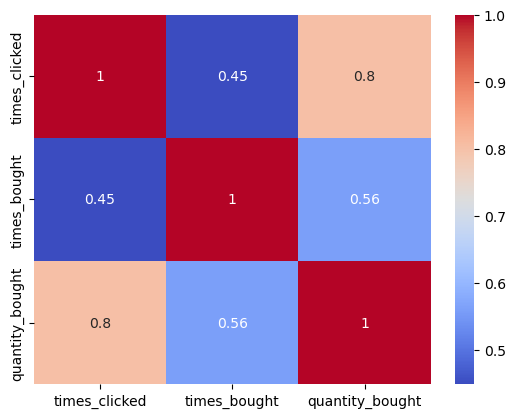

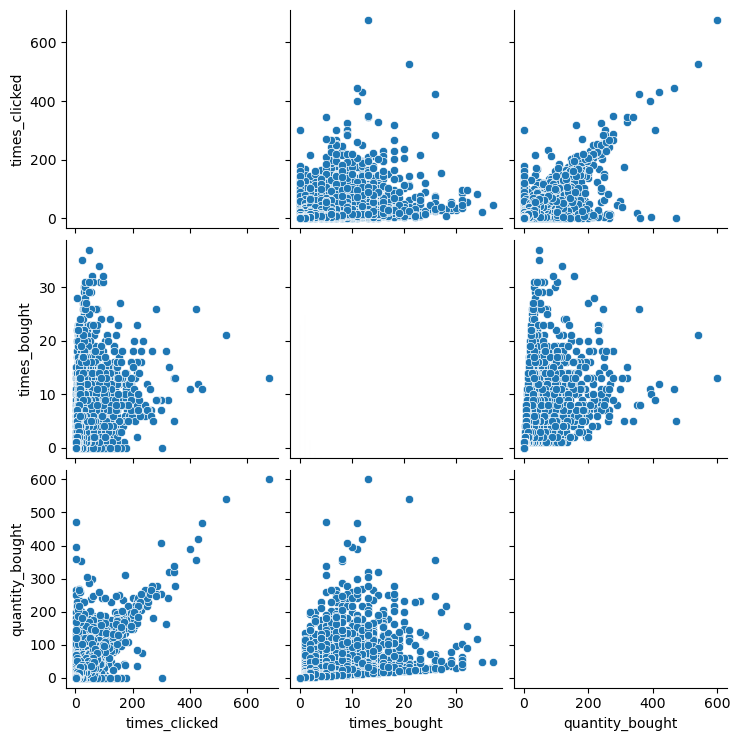

In [194]:
# Correlation matrix
correlation_matrix = df_dia[['times_clicked', 'times_bought', 'quantity_bought']].corr()

# Heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Pairplot
sns.pairplot(df_dia[['times_clicked', 'times_bought', 'quantity_bought']])
plt.show()

### 3.3 COLLABORATIVE FILTERING MODEL (CF)

Collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences from many users (collaborating). The underlying assumption is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.

# 4. MERGE BOTH DATASETS

In [195]:
unique_ids_filtered = filtered_df['product_external_id'].nunique()
unique_names_filtered = filtered_df['product_name'].nunique()
unique_ids_dia = df_dia['product_external_id'].nunique()
unique_names_dia = df_dia['product_name'].nunique()

print("Unique IDs in filtered_df:", unique_ids_filtered)
print("Unique Names in filtered_df:", unique_names_filtered)
print("Unique IDs in df_dia:", unique_ids_dia)
print("Unique Names in df_dia:", unique_names_dia)

Unique IDs in filtered_df: 8442
Unique Names in filtered_df: 8416
Unique IDs in df_dia: 6499
Unique Names in df_dia: 8040


In [196]:
filtered_df['product_external_id'] = filtered_df['product_external_id'].astype(str).str.strip().str.lower()
filtered_df['product_name'] = filtered_df['product_name'].str.strip().str.lower()

df_dia['product_external_id'] = df_dia['product_external_id'].astype(str).str.strip().str.lower()
df_dia['product_name'] = df_dia['product_name'].str.strip().str.lower()

combined_df = pd.merge(filtered_df, df_dia, on=['product_external_id', 'product_name'], how='inner')

print(combined_df.head())
print("Number of rows in combined dataset:", combined_df.shape[0])

  product_external_id                                 product_name  \
0                 101  aceite refinado de girasol dia botella 1 l.   
1                 101  aceite refinado de girasol dia botella 1 l.   
2                 101  aceite refinado de girasol dia botella 1 l.   
3                 101  aceite refinado de girasol dia botella 1 l.   
4                 101  aceite refinado de girasol dia botella 1 l.   

  product_description  product_price  \
0                               1.53   
1                               1.53   
2                               1.53   
3                               1.53   
4                               1.53   

                                   product_image_url  \
0  https://images.deliveryhero.io/image/global-ca...   
1  https://images.deliveryhero.io/image/global-ca...   
2  https://images.deliveryhero.io/image/global-ca...   
3  https://images.deliveryhero.io/image/global-ca...   
4  https://images.deliveryhero.io/image/global-ca...   

 

## 4.1 Review Results

In [197]:
# Check for duplicates
duplicate_rows = combined_df.duplicated(subset=['product_external_id', 'customer_id'], keep=False)
print("Number of duplicate rows:", duplicate_rows.sum())
print(combined_df[duplicate_rows].sort_values(by=['product_external_id', 'customer_id']))

# Check for any unusual data entries
print("Entries with zero interactions but have purchase data:")
print(combined_df[(combined_df['times_clicked'] == 0) & (combined_df['times_bought'] > 0)])

print("Summary statistics for numerical fields:")
print(combined_df[['times_clicked', 'times_bought', 'quantity_bought', 'product_price']].describe())

print("Non-null count in each column:")
print(combined_df.notnull().sum())

Number of duplicate rows: 8652
       product_external_id                                       product_name  \
375463              100267  galletas estrellas con chocolate con leche lu ...   
375486              100267  galletas estrellas con chocolate con leche lu ...   
375387              100267  galletas estrellas con chocolate con leche lu ...   
375591              100267  galletas estrellas con chocolate con leche lu ...   
375315              100267  galletas estrellas con chocolate con leche lu ...   
...                    ...                                                ...   
514936               99265            agua mineral con gas dia botella 1.5 l.   
514267               99265            agua mineral con gas dia botella 1.5 l.   
514825               99265            agua mineral con gas dia botella 1.5 l.   
513554               99265            agua mineral con gas dia botella 1.5 l.   
514989               99265            agua mineral con gas dia botella 1.5 l. 

The presence of duplicates represent valid multiple transactions.

The situation where entries show zero interactions (times_clicked is zero) but still record purchases (times_bought and quantity_bought are greater than zero) could indicate data issues.

In [198]:
# Check for duplicates across all columns
dia_duplicates = df_dia.duplicated(keep=False)
print(f"Total duplicates in df_dia: {dia_duplicates.sum()}")

if dia_duplicates.sum() > 0:
    print(df_dia[dia_duplicates].sort_values(by='product_external_id').head())

Total duplicates in df_dia: 8
         customer_id  store_id        store_name product_external_id  \
10430        5830994      9542  Supermercado DIA              156729   
10431        5830994      9542  Supermercado DIA              156729   
415395       5830994      9542  Supermercado DIA              156729   
415396       5830994      9542  Supermercado DIA              156729   
2602425    136918858      2741  Supermercado DIA              156729   

                                            product_name  times_clicked  \
10430           mars barrita de chocolate y caramelo 51g              2   
10431           mars barrita de chocolate y caramelo 51g              2   
415395   barrita de chocolate y caramelo mars bolsa 51 g              2   
415396   barrita de chocolate y caramelo mars bolsa 51 g              2   
2602425  barrita de chocolate y caramelo mars bolsa 51 g              4   

         times_bought  quantity_bought  click_to_purchase_ratio  purchase_freq  
10430

In [199]:
filtered_df['doc_vector'] = filtered_df['doc_vector'].apply(lambda x: np.array2string(x) if isinstance(x, np.ndarray) else x)

In [200]:
# Convert all elements to string 
for col in filtered_df.columns:
    filtered_df[col] = filtered_df[col].apply(lambda x: str(x) if isinstance(x, (list, dict, np.ndarray)) else x)

try:
    filtered_duplicates = filtered_df.duplicated(keep=False)
    print(f"Total duplicates in filtered_df: {filtered_duplicates.sum()}")
    if filtered_duplicates.sum() > 0:
        print(filtered_df[filtered_duplicates].head())
except Exception as e:
    print("Error when checking duplicates:", e)

Total duplicates in filtered_df: 0


In [201]:
# Filter entries with zero clicks but non-zero purchases
zero_click_purchases = combined_df[(combined_df['times_clicked'] == 0) & (combined_df['times_bought'] > 0)]

# Examine distribution 
print(zero_click_purchases[['times_bought', 'quantity_bought']].describe())

category_analysis = zero_click_purchases['master_category_names'].value_counts()
print(category_analysis.head())

       times_bought  quantity_bought
count           0.0              0.0
mean            NaN              NaN
std             NaN              NaN
min             NaN              NaN
25%             NaN              NaN
50%             NaN              NaN
75%             NaN              NaN
max             NaN              NaN
Series([], Name: master_category_names, dtype: int64)


In [202]:
# Filter entries where times_clicked is zero but times_bought is greater than zero
zero_interaction_purchases = df_dia[(df_dia['times_clicked'] == 0) & (df_dia['times_bought'] > 0)]

zero_interaction_count = zero_interaction_purchases.shape[0]

zero_interaction_purchases_sample = zero_interaction_purchases.sample(n=min(5, zero_interaction_count))

print(f"Number of zero interaction but purchases: {zero_interaction_count}")
print(zero_interaction_purchases_sample)

Number of zero interaction but purchases: 0
Empty DataFrame
Columns: [customer_id, store_id, store_name, product_external_id, product_name, times_clicked, times_bought, quantity_bought, click_to_purchase_ratio, purchase_freq]
Index: []


## 4.2 Exploratory Data Analysis (EDA)

In [203]:
# Calculate the click-to-purchase ratio
combined_df['click_to_purchase_ratio'] = combined_df['times_bought'] / combined_df['times_clicked'].replace(0, np.nan)

# Identify products with high clicks but low purchases
low_conversion_products = combined_df.query('times_clicked > 10 and click_to_purchase_ratio < 0.1')

customer_behavior = combined_df.groupby('customer_id').agg(
    total_clicks=('times_clicked', 'sum'),
    total_purchases=('times_bought', 'sum')
).assign(behavior_type=lambda x: pd.cut(x['total_purchases'], bins=[-1, 1, 10, float('inf')], labels=['Low', 'Medium', 'High']))

# Price sensitivity analysis
price_sensitivity = combined_df[['product_price', 'click_to_purchase_ratio']].dropna()
correlation_matrix = price_sensitivity.corr()

category_trends = combined_df.groupby('master_category_names')['click_to_purchase_ratio'].mean()

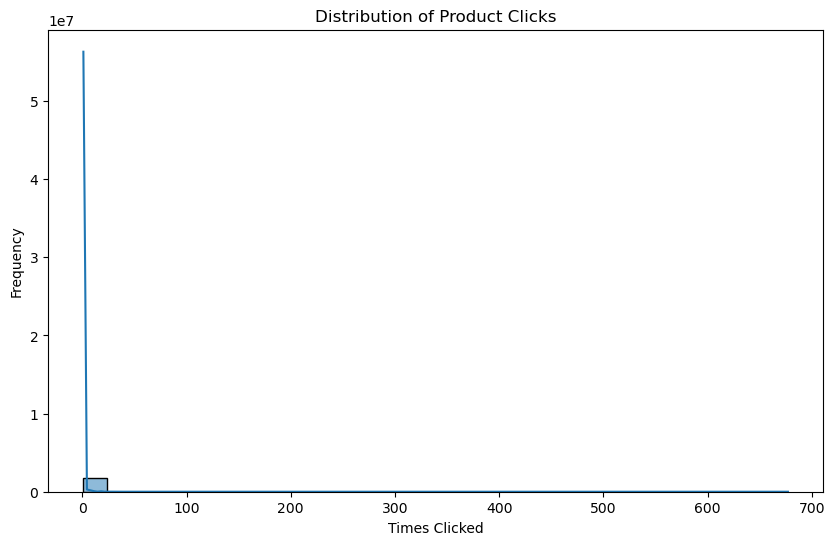

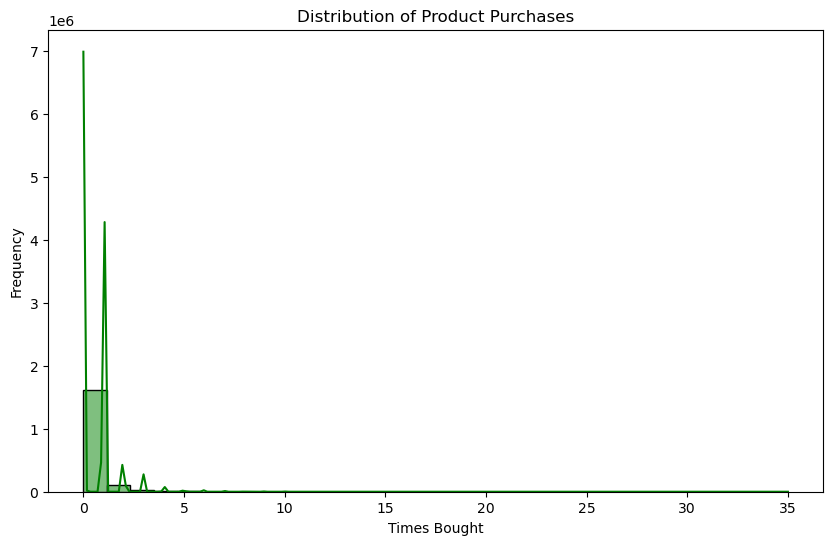

In [204]:
# Distribution of clicks
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['times_clicked'], bins=30, kde=True)
plt.title('Distribution of Product Clicks')
plt.xlabel('Times Clicked')
plt.ylabel('Frequency')
plt.show()

# Distribution of purchases
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['times_bought'], bins=30, kde=True, color='green')
plt.title('Distribution of Product Purchases')
plt.xlabel('Times Bought')
plt.ylabel('Frequency')
plt.show()

This highly skewed distribution indicates that most products are clicked very infrequently, with a few products receiving a majority of the clicks.

This kind of distribution is common in real-world scenarios, especially in e-commerce, where a small number of items often dominate the traffic.

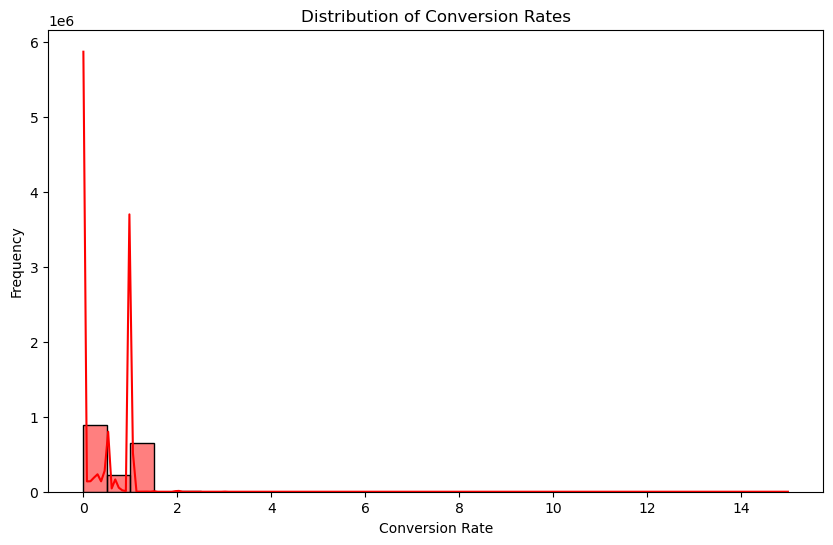

In [205]:
# Calculate the conversion rate as times_bought divided by times_clicked
combined_df['conversion_rate'] = combined_df['times_bought'] / combined_df['times_clicked'].replace(0, np.nan)

# Plotting conversion rate
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['conversion_rate'].dropna(), bins=30, color='red', kde=True)
plt.title('Distribution of Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')
plt.show()

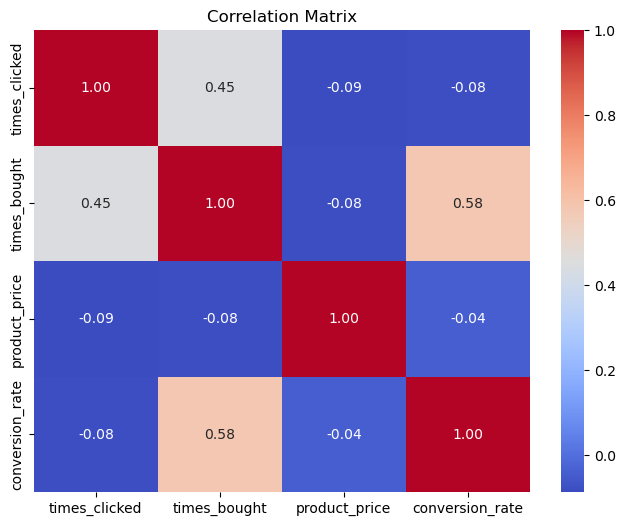

In [206]:
# Correlation matrix
correlation_matrix = combined_df[['times_clicked', 'times_bought', 'product_price', 'conversion_rate']].corr()

# Heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Times Clicked and Product Price: The correlation is -0.09, indicating a very weak negative relationship. This suggests that as the product price increases, there might be a slight decrease in the number of times a product is clicked, but the effect is minimal.

Times Bought and Product Price: Similarly, there's a weak negative correlation of -0.08, indicating that more expensive products are slightly less likely to be bought, though again, the effect is not strong.

The correlation between Product Price and Conversion Rate shows a very weak positive correlation of 0.05. This implies that there is essentially no meaningful linear relationship between the price of a product and the likelihood that it is bought after being clicked. Price doesn't appear to strongly influence whether a click converts into a purchase in this dataset.

However, a low correlation in this context does not imply that price has no effect on purchase behavior; it simply means there is no strong linear relationship. The effect of price on purchasing decisions could be non-linear or influenced by other factors like product category, brand loyalty, or the perceived value of the product.

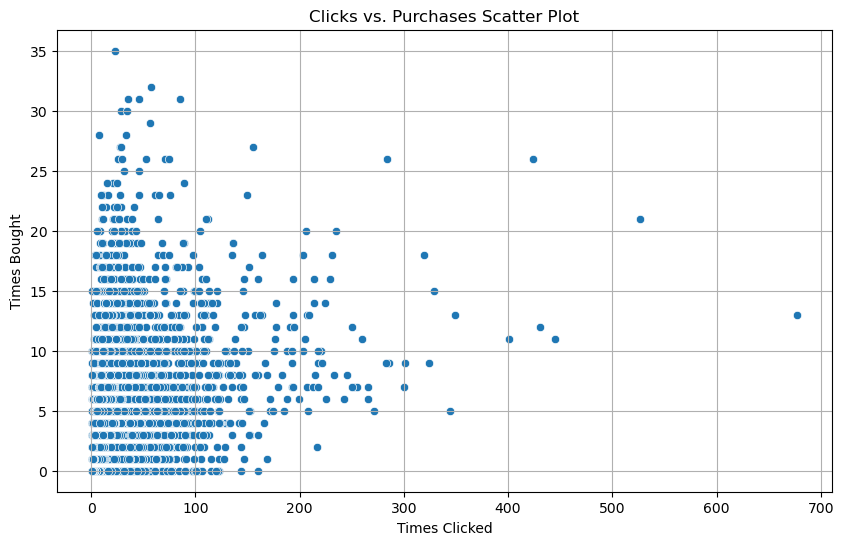

In [207]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='times_clicked', y='times_bought')
plt.title('Clicks vs. Purchases Scatter Plot')
plt.xlabel('Times Clicked')
plt.ylabel('Times Bought')
plt.grid(True)
plt.show()

In [208]:
# Identify products with high clicks but low purchases
low_conversion_products = combined_df.query('times_clicked > 10 and click_to_purchase_ratio < 0.1')

# Analyse customer behavior segmentation
customer_behavior = combined_df.groupby('customer_id').agg(
    total_clicks=('times_clicked', 'sum'),
    total_purchases=('times_bought', 'sum')
).assign(behavior_type=lambda x: pd.cut(x['total_purchases'], bins=[-1, 1, 10, float('inf')], labels=['Low', 'Medium', 'High']))

# Price sensitivity analysis
price_sensitivity = combined_df[['product_price', 'click_to_purchase_ratio']].dropna()
correlation_matrix = price_sensitivity.corr()

# Common trends in low conversion products
category_trends = combined_df.groupby('master_category_names')['click_to_purchase_ratio'].mean()

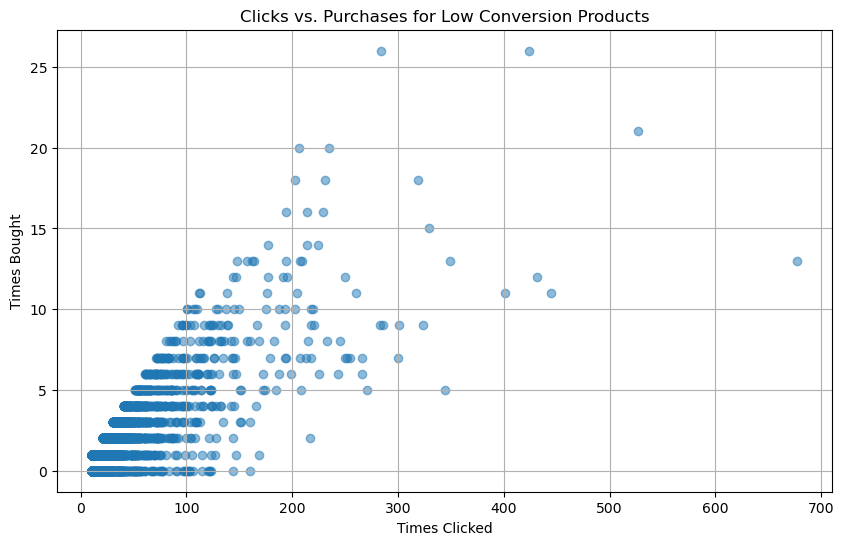

In [209]:
# Plotting clicks vs. purchases for low conversion products
plt.figure(figsize=(10, 6))
plt.scatter(low_conversion_products['times_clicked'], low_conversion_products['times_bought'], alpha=0.5)
plt.title('Clicks vs. Purchases for Low Conversion Products')
plt.xlabel('Times Clicked')
plt.ylabel('Times Bought')
plt.grid(True)
plt.show()

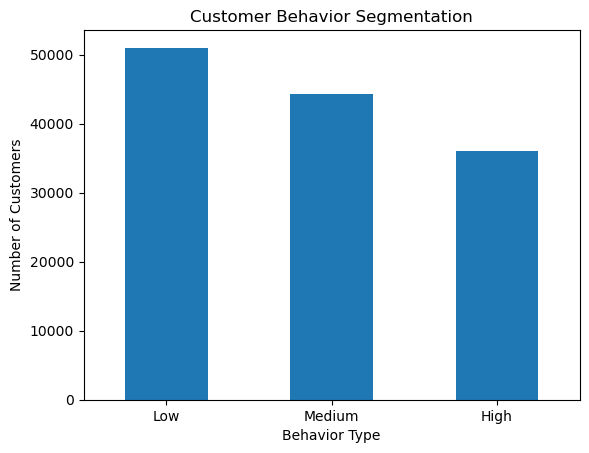

In [210]:
# Plot distribution of customer behavior types
customer_behavior['behavior_type'].value_counts().plot(kind='bar')
plt.title('Customer Behavior Segmentation')
plt.xlabel('Behavior Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

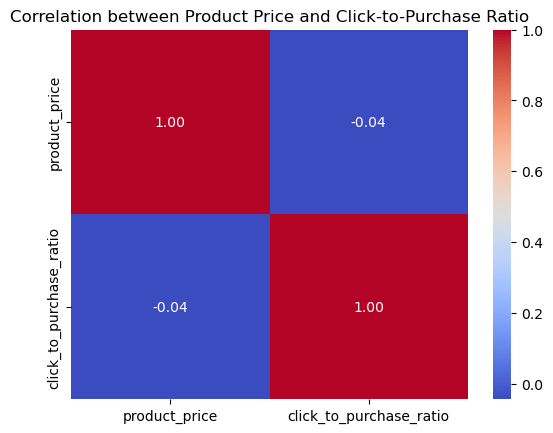

In [211]:
# Heatmap of correlations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Product Price and Click-to-Purchase Ratio')
plt.show()

Very low correlation (-0.04) between product price and the click-to-purchase ratio. This suggests that, at least across the dataset as a whole, there isn't a strong linear relationship between the price of a product and how often it is clicked compared to how often it is bought.

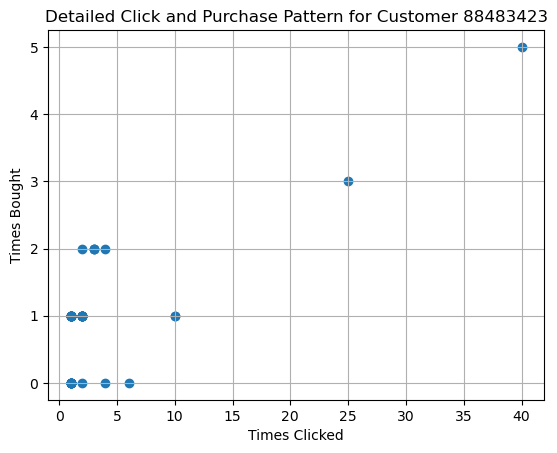

In [212]:
# Detailed analysis for a specific customer
customer_id_example = 88483423 
customer_data = combined_df[combined_df['customer_id'] == customer_id_example]
plt.scatter(customer_data['times_clicked'], customer_data['times_bought'])
plt.title(f'Detailed Click and Purchase Pattern for Customer {customer_id_example}')
plt.xlabel('Times Clicked')
plt.ylabel('Times Bought')
plt.grid(True)
plt.show()

In [213]:
print("Data Types in filtered_df:")
print(filtered_df[['product_external_id', 'product_name']].dtypes)

print("\nData Types in df_dia:")
print(df_dia[['product_external_id', 'product_name']].dtypes)

print("\nSample data in filtered_df:")
print(filtered_df[['product_external_id', 'product_name']].head())

print("\nSample data in df_dia:")
print(df_dia[['product_external_id', 'product_name']].head())

# Apply necessary transformations
filtered_df['product_external_id'] = filtered_df['product_external_id'].str.strip().str.lower()
filtered_df['product_name'] = filtered_df['product_name'].str.strip().str.lower()

df_dia['product_external_id'] = df_dia['product_external_id'].str.strip().str.lower()
df_dia['product_name'] = df_dia['product_name'].str.strip().str.lower()

combined_df = pd.merge(filtered_df, df_dia, on=['product_external_id', 'product_name'], how='inner')

print("\nColumns in combined_df:")
print(combined_df.columns)
print("\nNumber of columns in filtered_df:", len(filtered_df.columns))
print("Number of columns in combined_df after merge:", len(combined_df.columns))

Data Types in filtered_df:
product_external_id    object
product_name           object
dtype: object

Data Types in df_dia:
product_external_id    object
product_name           object
dtype: object

Sample data in filtered_df:
  product_external_id                                       product_name
0              292092  queso de oveja curado insolito el cencerro 200...
1                 101        aceite refinado de girasol dia botella 1 l.
2              197503           levadura en polvo delimagic sobre 90 gr.
3              279225   licor de mora sin alcohol sonador botella 70 cl.
4              189160       caldo casero de verduras gallina blanca 1 l.

Sample data in df_dia:
  product_external_id                                       product_name
0               88697  rosquillas de chocolate el molino de dia 4 uds...
1              264423          ensaladilla rusa al punto bandeja 250 gr.
3               50569  refresco de té al melocotón dia freshquitos bo...
5              1298

In [214]:
# Calculate price per unit
combined_df['price_per_unit'] = np.where(
    combined_df['product_weight_in_grams'] > 0,
    combined_df['product_price'] / combined_df['product_weight_in_grams'],
    np.where(
        combined_df['product_in_quantities'] > 0,
        combined_df['product_price'] / combined_df['product_in_quantities'],
        np.nan  # Handle cases where both weights and quantities might be missing
    )
)

# Drop rows where price_per_unit could not be calculated
combined_df = combined_df.dropna(subset=['price_per_unit'])

# Function to calculate quartiles for price segmentation
def assign_price_segment(x):
    try:
        return pd.qcut(x, 4, labels=['Lowest 25%', '25% to 50%', '50% to 75%', 'Top 25%'], duplicates='drop')
    except ValueError:
        return pd.Series(['Not enough data'] * len(x), index=x.index)

# Apply the function to segment price within each category
combined_df['price_segment'] = combined_df.groupby('master_category_names')['price_per_unit'].transform(assign_price_segment)

print(combined_df[['master_category_names', 'product_price', 'product_weight_in_grams', 'product_in_quantities', 'price_per_unit', 'price_segment']].head())

                               master_category_names  product_price  \
0  packaged foods_cooking / condiments / baking /...           1.53   
1  packaged foods_cooking / condiments / baking /...           1.53   
2  packaged foods_cooking / condiments / baking /...           1.53   
3  packaged foods_cooking / condiments / baking /...           1.53   
4  packaged foods_cooking / condiments / baking /...           1.53   

   product_weight_in_grams  product_in_quantities  price_per_unit  \
0                   1021.0                    NaN        0.001499   
1                   1021.0                    NaN        0.001499   
2                   1021.0                    NaN        0.001499   
3                   1021.0                    NaN        0.001499   
4                   1021.0                    NaN        0.001499   

  price_segment  
0    Lowest 25%  
1    Lowest 25%  
2    Lowest 25%  
3    Lowest 25%  
4    Lowest 25%  


In [215]:
# Calculate the average click-to-purchase ratio for each price segment within each category
average_click_to_purchase_by_category_and_segment = combined_df.groupby(['master_category_names', 'price_segment'])['click_to_purchase_ratio'].mean()

average_click_to_purchase_by_category_and_segment = average_click_to_purchase_by_category_and_segment.reset_index()

print(average_click_to_purchase_by_category_and_segment)

                                 master_category_names    price_segment  \
0    beverages_juice / ice tea / sports / energy_en...  Not enough data   
1    beverages_juice / ice tea / sports / energy_juice       25% to 50%   
2    beverages_juice / ice tea / sports / energy_juice       50% to 75%   
3    beverages_juice / ice tea / sports / energy_juice       Lowest 25%   
4    beverages_juice / ice tea / sports / energy_juice          Top 25%   
..                                                 ...              ...   
395      snacks_salty snacks_salty crackers / pretzels       25% to 50%   
396      snacks_salty snacks_salty crackers / pretzels       50% to 75%   
397      snacks_salty snacks_salty crackers / pretzels       Lowest 25%   
398      snacks_salty snacks_salty crackers / pretzels          Top 25%   
399               snacks_salty snacks_specialty snacks  Not enough data   

     click_to_purchase_ratio  
0                   0.481084  
1                   0.470708  
2     

There appears to be variability in the click-to-purchase ratio within each category depending on the price segment. For example, for 'beverages_juice / ice tea / sports / energy', the lowest 25% price segment has a higher click-to-purchase ratio than the top 25%.

In [216]:
# Calculate the average click-to-purchase ratio for each category and price segment
average_click_to_purchase_by_category_and_segment = combined_df.groupby(['master_category_names', 'price_segment'])['click_to_purchase_ratio'].mean()

average_click_to_purchase_by_category_and_segment = average_click_to_purchase_by_category_and_segment.reset_index()

overall_average_by_price_segment = average_click_to_purchase_by_category_and_segment.groupby('price_segment')['click_to_purchase_ratio'].mean()

overall_average_by_price_segment = overall_average_by_price_segment.reset_index()

print(overall_average_by_price_segment)

     price_segment  click_to_purchase_ratio
0       25% to 50%                 0.425786
1       50% to 75%                 0.417684
2       Lowest 25%                 0.437489
3  Not enough data                 0.391322
4          Top 25%                 0.391627


When aggregated, the lowest 25% price segment tends to have a slightly higher click-to-purchase ratio than other segments. This could suggest that cheaper products generally have a better conversion rate, though the differences are not substantial.

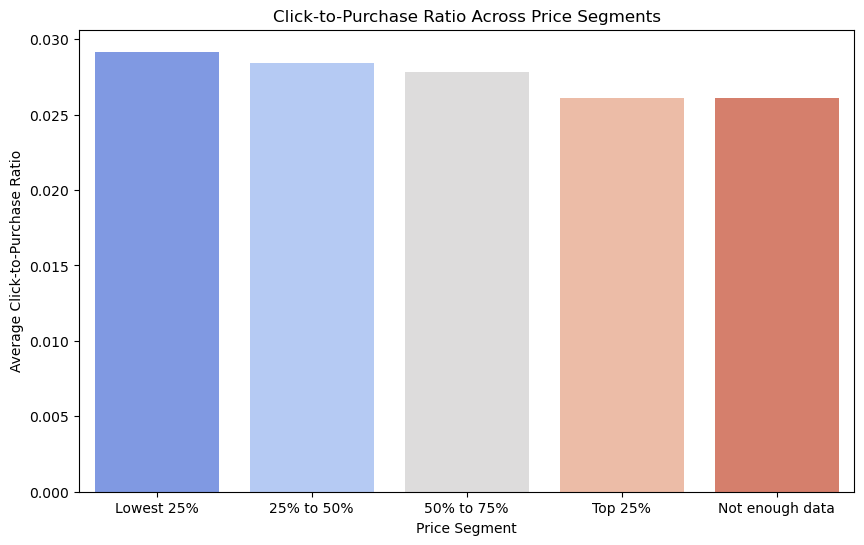

In [217]:
results = pd.DataFrame({
    'price_segment': ['Lowest 25%', '25% to 50%', '50% to 75%', 'Top 25%', 'Not enough data'],
    'click_to_purchase_ratio': [0.029166, 0.028386, 0.027846, 0.026108, 0.026088]
})

# Bar Chart for overall price segments
plt.figure(figsize=(10, 6))
sns.barplot(x='price_segment', y='click_to_purchase_ratio', data=results, palette='coolwarm')
plt.title('Click-to-Purchase Ratio Across Price Segments')
plt.xlabel('Price Segment')
plt.ylabel('Average Click-to-Purchase Ratio')
plt.show()

## 4.3 Implementation

### 4.3.1 Subset Implementation

In [218]:
# Calculate total purchases for each customer
customer_purchases = df_dia.groupby('customer_id')['times_bought'].sum()

# Sort customers and get the top 50
top_customers = customer_purchases.sort_values(ascending=False).head(50)
top_customers_df = df_dia[df_dia['customer_id'].isin(top_customers.index)]
top_customers_df.to_csv('top_customers.csv', index=False)

In [219]:
top_customers_df = top_customers_df.copy()

# Strip whitespace and convert to lower case
filtered_df['product_external_id'] = filtered_df['product_external_id'].str.strip().str.lower()
filtered_df['product_name'] = filtered_df['product_name'].str.strip().str.lower()

top_customers_df['product_external_id'] = top_customers_df['product_external_id'].str.strip().str.lower()
top_customers_df['product_name'] = top_customers_df['product_name'].str.strip().str.lower()

In [220]:
combined_small_df = pd.merge(filtered_df, top_customers_df, on=['product_external_id', 'product_name'], how='left')

print(f"Merged dataframe has {combined_small_df.shape[0]} rows.")

Merged dataframe has 12363 rows.


In [221]:
model = SentenceTransformer('all-MiniLM-L6-v2')
texts = filtered_df['combined_text'].tolist()
embeddings = model.encode(texts)

filtered_df['embeddings'] = list(embeddings)

In [222]:
top_customers_df = pd.read_csv('top_customers.csv')

filtered_df['product_external_id'] = filtered_df['product_external_id'].str.strip().str.lower()
filtered_df['product_name'] = filtered_df['product_name'].str.strip().str.lower()

top_customers_df['product_external_id'] = top_customers_df['product_external_id'].str.strip().str.lower()
top_customers_df['product_name'] = top_customers_df['product_name'].str.strip().str.lower()

In [223]:
def find_similar_products(df, product_index, top_n=50):
    target_embedding = [df.iloc[product_index]['embeddings']] 
    target_category = df.iloc[product_index]['master_category_names']
    
    same_category_df = df[df['master_category_names'] == target_category]
    
    # Compute the cosine similarity with all products in the same category
    similarity_scores = cosine_similarity(target_embedding, same_category_df['embeddings'].tolist())[0]
    
    top_indices = np.argsort(similarity_scores)[::-1][:top_n + 1] 
    top_indices = [idx for idx in top_indices if same_category_df.index[idx] != product_index] 
    return same_category_df.iloc[top_indices][['product_name_english', 'master_category_names', 'product_external_id']]

def recommend_products(customer_id, out_of_stock_product_id, top_n=50):

    product_index = filtered_df[filtered_df['product_external_id'] == out_of_stock_product_id].index[0]
    
    similar_products_df = find_similar_products(filtered_df, product_index, top_n)
    
    # Get products the customer has bought or clicked more than once
    customer_product_interactions = top_customers_df[top_customers_df['customer_id'] == customer_id]
    frequent_interactions = customer_product_interactions[
        (customer_product_interactions['times_bought'] > 0) | 
        (customer_product_interactions['times_clicked'] > 1)
    ]['product_external_id'].tolist()
    
    similar_products_df['interacted_before'] = similar_products_df['product_external_id'].apply(lambda x: 'Yes' if x in frequent_interactions else 'No')
    
    # Filter similar products based on customer frequent interactions
    recommended_products = similar_products_df[similar_products_df['interacted_before'] == 'Yes']
    
    # If there are fewer than 5 frequent interactions, add more recommendations to fill up to 5
    if len(recommended_products) < 5:
        additional_products = similar_products_df[similar_products_df['interacted_before'] == 'No'].head(5 - len(recommended_products))
        recommended_products = pd.concat([recommended_products, additional_products])
    
    return recommended_products.head(5)

In [224]:
# Specify the customer ID and out of stock product ID
specific_customer_id = 53079619
out_of_stock_product_id = '282904'

# Get recommendations
recommendations = recommend_products(specific_customer_id, out_of_stock_product_id, top_n=50)
print(recommendations)

                                product_name_english  \
2356  marinated pork loin dia selection tray 700 gr.   
3322  classic imperial longaniza elpozo tray 250 gr.   
1101    chicken longaniza dia selection tray 400 gr.   
2615          pages sola longaniza packaging 250 gr.   
7934  imperial longaniza with turkey el pozo 230 gr.   

                                 master_category_names product_external_id  \
2356  dairy / chilled / eggs_deli / snacking_deli meat              111575   
3322  dairy / chilled / eggs_deli / snacking_deli meat              290666   
1101  dairy / chilled / eggs_deli / snacking_deli meat              275700   
2615  dairy / chilled / eggs_deli / snacking_deli meat              140398   
7934  dairy / chilled / eggs_deli / snacking_deli meat              262367   

     interacted_before  
2356               Yes  
3322                No  
1101                No  
2615                No  
7934                No  


In [225]:
# Specify the customer ID and out of stock product ID
specific_customer_id = 53079619
out_of_stock_product_id = '274754'

# Get recommendations
recommendations = recommend_products(specific_customer_id, out_of_stock_product_id, top_n=50)
print(recommendations)

                                   product_name_english  \
3781      mortadella sliced dia nuestra alacena 250 gr.   
6294  mortadella with olives slices dia nuestra alac...   
6508  chorizo iberico en lonchas dia nuestra alacena...   
2411  chorizo y salchichon extra dia nuestra alacena...   
4771  reserve serrano ham slices dia nuestra alacena...   

                                 master_category_names product_external_id  \
3781  dairy / chilled / eggs_deli / snacking_deli meat              273960   
6294  dairy / chilled / eggs_deli / snacking_deli meat              273961   
6508  dairy / chilled / eggs_deli / snacking_deli meat              273996   
2411  dairy / chilled / eggs_deli / snacking_deli meat              273991   
4771  dairy / chilled / eggs_deli / snacking_deli meat              274051   

     interacted_before  
3781               Yes  
6294               Yes  
6508               Yes  
2411               Yes  
4771               Yes  


In [226]:
# Specify the customer ID and out of stock product ID
specific_customer_id = 133256310
out_of_stock_product_id = '274754'

# Get recommendations
recommendations = recommend_products(specific_customer_id, out_of_stock_product_id, top_n=50)
print(recommendations)

                                   product_name_english  \
3781      mortadella sliced dia nuestra alacena 250 gr.   
3247    extra espetec dia nuestra alacena piece 170 gr.   
5393     chopped pork dia nuestra alacena piece 500 gr.   
5828    maxi york ham dia nuestra alacena piece 800 gr.   
3332  extra sweet sarta chorizo dia nuestra alacena ...   

                                 master_category_names product_external_id  \
3781  dairy / chilled / eggs_deli / snacking_deli meat              273960   
3247  dairy / chilled / eggs_deli / snacking_deli meat              274137   
5393  dairy / chilled / eggs_deli / snacking_deli meat              274755   
5828  dairy / chilled / eggs_deli / snacking_deli meat              273746   
3332  dairy / chilled / eggs_deli / snacking_deli meat              273976   

     interacted_before  
3781                No  
3247                No  
5393                No  
5828                No  
3332                No  


In [227]:
# Specify the customer ID and category
specific_customer_id = 53079619
category = 'dairy / chilled / eggs_deli / snacking_deli meat'

customer_data = combined_small_df[(combined_small_df['customer_id'] == specific_customer_id) &
                                  (combined_small_df['master_category_names'] == category)]

print(customer_data)

     product_external_id                                       product_name  \
1969              273749  bacon en lonchas dia nuestra alacena envase 20...   
2892               15976                       chorizo revilla sobre 65 gr.   
5070              273976  chorizo extra dulce sarta dia nuestra alacena ...   
5744              273960   mortadela en lonchas dia nuestra alacena 250 gr.   
5959              273988  chorizo extra en lonchas dia nuestra alacena 2...   
7588              273952  mortadela de pavo finas lonchas dia nuestra al...   
7820              137167               fiambre de york elpozo sobre 300 gr.   
9535              273961  mortadela con aceitunas lonchas dia nuestra al...   

     product_description  product_price  \
1969                               2.05   
2892                               1.00   
5070                               2.73   
5744                               1.53   
5959                               2.05   
7588                          

In [228]:
# Filter the DataFrame for this specific customer
specific_customer_id = 53079619
customer_data = top_customers_df[top_customers_df['customer_id'] == specific_customer_id]

# Filter for products that the customer has bought and clicked at least more than once
filtered_customer_data = customer_data[(customer_data['times_bought'] > 0) | (customer_data['times_clicked'] > 1)]

print(filtered_customer_data)

      customer_id  store_id        store_name product_external_id  \
0        53079619     51368  Supermercado DIA              273998   
94       53079619     51368  Supermercado DIA               50652   
181      53079619     51368  Supermercado DIA              215665   
197      53079619     51368  Supermercado DIA              142776   
234      53079619     51368  Supermercado DIA               64505   
...           ...       ...               ...                 ...   
9537     53079619     51368  Supermercado DIA              263267   
9726     53079619     51368  Supermercado DIA              273961   
9741     53079619     51368  Supermercado DIA              295308   
9826     53079619     51368  Supermercado DIA              273749   
9866     53079619     51368  Supermercado DIA               82954   

                                           product_name  times_clicked  \
0     detergente líquido marsella dia super paco 61 lv.              1   
94      queso rallado m

### 4.3.2 Implementation of whole dataset

In [229]:
filtered_df['product_external_id'] = filtered_df['product_external_id'].str.strip().str.lower()
filtered_df['product_name'] = filtered_df['product_name'].str.strip().str.lower()

df_dia['product_external_id'] = df_dia['product_external_id'].str.strip().str.lower()
df_dia['product_name'] = df_dia['product_name'].str.strip().str.lower()

In [230]:
# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert combined texts to list and compute embeddings
texts = filtered_df['combined_text'].tolist()
embeddings = model.encode(texts)

filtered_df['embeddings'] = list(embeddings)

In [231]:
def find_similar_products(df, product_index, top_n=50):
    target_embedding = [df.iloc[product_index]['embeddings']]
    target_category = df.iloc[product_index]['master_category_names']
    
    same_category_df = df[df['master_category_names'] == target_category]
    
    similarity_scores = cosine_similarity(target_embedding, same_category_df['embeddings'].tolist())[0]
    
    top_indices = np.argsort(similarity_scores)[::-1][:top_n + 1]
    top_indices = [idx for idx in top_indices if same_category_df.index[idx] != product_index]
    
    return same_category_df.iloc[top_indices][['product_name_english', 'master_category_names', 'product_external_id']]

def recommend_products(customer_id, out_of_stock_product_id, top_n=50):
    product_index = filtered_df[filtered_df['product_external_id'] == out_of_stock_product_id].index[0]
    similar_products_df = find_similar_products(filtered_df, product_index, top_n)
    
    customer_product_interactions = df_dia[df_dia['customer_id'] == customer_id]
    frequent_interactions = customer_product_interactions[
        (customer_product_interactions['times_bought'] > 0) | 
        (customer_product_interactions['times_clicked'] > 1)
    ]['product_external_id'].tolist()
    
    similar_products_df['interacted_before'] = similar_products_df['product_external_id'].apply(lambda x: 'Yes' if x in frequent_interactions else 'No')
    recommended_products = similar_products_df[similar_products_df['interacted_before'] == 'Yes']
    
    if len(recommended_products) < 5:
        additional_products = similar_products_df[similar_products_df['interacted_before'] == 'No'].head(5 - len(recommended_products))
        recommended_products = pd.concat([recommended_products, additional_products])
    
    return recommended_products.head(5)

In [232]:
# Select a random customer
random_customer_id = df_dia['customer_id'].sample().iloc[0]
print(f"Random Customer ID: {random_customer_id}")

# Get past purchases and clicks for the random customer
customer_interactions = df_dia[df_dia['customer_id'] == random_customer_id]
print("Past Purchases and Clicks for Customer:")
print(customer_interactions[['store_name', 'product_name', 'times_clicked', 'times_bought']])

Random Customer ID: 163361988
Past Purchases and Clicks for Customer:
               store_name                                       product_name  \
287218   Supermercado DIA  chicles sabor hierbabuena sin azúcar iceberg b...   
609930   Supermercado DIA  barrita proteína stracciatella just loading 35...   
747811   Supermercado DIA               bebida de soja dia vital envase 1 l.   
1015156  Supermercado DIA  pudding sabor chocolate con proteínas yopro va...   
1156590  Supermercado DIA  guantes nitrilo desechables talla m bayeco caj...   
1206281  Supermercado DIA  batido dietético de chocolate bicentury 5 batidos   
1315654  Supermercado DIA  tortitas de arroz bañadas yogur dia paquete 13...   
1646261  Supermercado DIA  chicles sabor menta fuerte sin azúcar iceberg ...   
1791591  Supermercado DIA  gel desatascador para tuberías dia super paco ...   
1964537  Supermercado DIA    chicle grageas sabor menta trident bolsa 44 gr.   
2477558  Supermercado DIA  papel higiénico compact

In [233]:
# Select a random out-of-stock product for the random customer
random_product_id = customer_interactions['product_external_id'].sample().iloc[0]
print(f"Random Out-of-Stock Product ID: {random_product_id}")

# Get recommendations
recommendations = recommend_products(random_customer_id, random_product_id, top_n=50)
print("Recommendations:")
print(recommendations)

Random Out-of-Stock Product ID: 3027
Recommendations:
                           product_name_english  \
4811                vegedia bebida de aveia 1 l   
1314      soy drink 0% sugar vegedia brick 1 l.   
5011                oat milk natural vegedia 1l   
1562  soy drink with calcium vegedia brick 1 l.   
7866             almond milk natural vegedia 1l   

                              master_category_names product_external_id  \
4811  dairy / chilled / eggs_milk_milk alternatives              207399   
1314  dairy / chilled / eggs_milk_milk alternatives              294323   
5011  dairy / chilled / eggs_milk_milk alternatives              267682   
1562  dairy / chilled / eggs_milk_milk alternatives              294324   
7866  dairy / chilled / eggs_milk_milk alternatives              267684   

     interacted_before  
4811                No  
1314                No  
5011                No  
1562                No  
7866                No  
